In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
! pip install xarray netCDF4
! pip install tensorflow
! pip install hmmlearn
! pip install pmdarima

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from hmmlearn.hmm import GaussianHMM

In [4]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}

# NOAA DATA

In [ ]:
link_noaa = 'https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.mon.land_ocean.90S.90N.v6.0.0.202410.asc'

columns = ["Year", "Month", "Anomaly(K)", "Total_Error(K^2)", "High_Freq_Error(K^2)",
           "Low_Freq_Error(K^2)", "Bias_Error(K^2)", "Diagnostic1", "Diagnostic2", "Diagnostic3"]
data = pd.read_csv('https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.mon.land_ocean.90S.90N.v6.0.0.202410.asc', delim_whitespace=True, names=columns, comment="#")

data["Date"] = pd.to_datetime(data[["Year", "Month"]].assign(day=1))
data.set_index("Date", inplace=True)

data = data[["Anomaly(K)"]]

print(data.tail())

<ipython-input-84-b7620f6de524>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.mon.land_ocean.90S.90N.v6.0.0.202410.asc', delim_whitespace=True, names=columns, comment="#")


            Anomaly(K)
Date                  
2024-06-01    0.908212
2024-07-01    0.911604
2024-08-01    0.971617
2024-09-01    0.964252
2024-10-01    1.063060


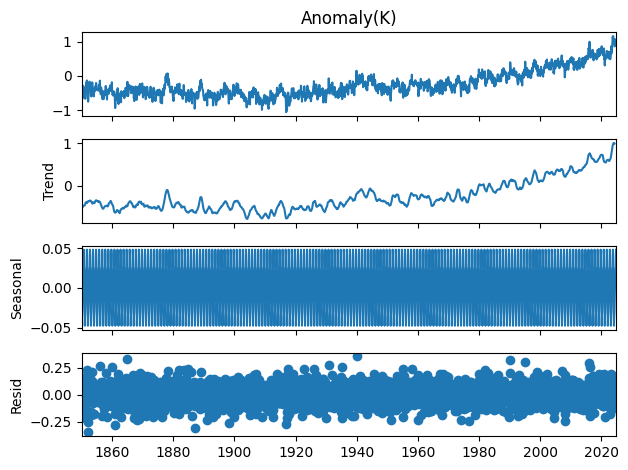

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(data["Anomaly(K)"], model="additive", period=12)
result.plot()
plt.show()

In [ ]:
# Count total values and NaN values
total_values = data["Anomaly(K)"].size
missing_values = data["Anomaly(K)"].isnull().sum().item()

# Percentage of missing values
print(f"Total values: {total_values}")
print(f"Missing values: {missing_values}")
percent_missing = (missing_values / total_values) * 100
print(f"Percentage of missing values: {percent_missing:.2f}%")

Total values: 2098
Missing values: 0
Percentage of missing values: 0.00%


In [ ]:
time_series = data["Anomaly(K)"].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)  # last year for testing
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
# Perform ADF test
result = adfuller(time_series)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")

ADF Statistic: -0.12798523162702352
p-value: 0.9465787674733017
Series is non-stationary. Differencing is needed.


In [ ]:
diff_series = np.diff(time_series, n=1)

# Recheck stationarity
result = adfuller(diff_series)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 9.408554718139158e-25


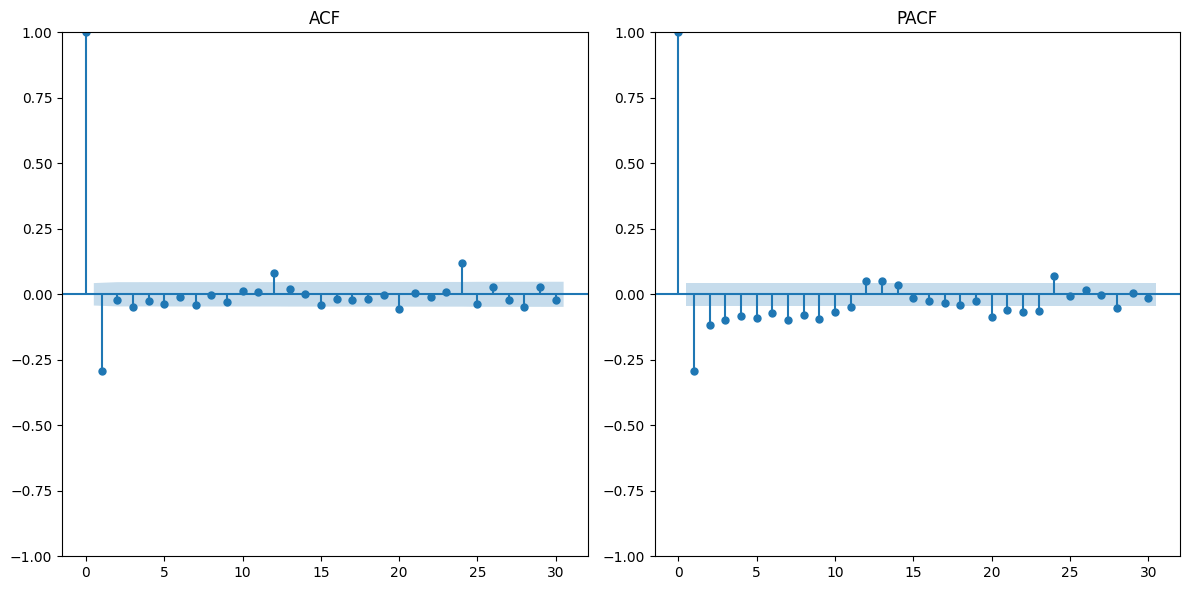

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# Predict on the test set
pred = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, pred)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.05429756261146409, 'MAPE': 5.4390435886868795, 'RMSE': 0.0686616944631873, 'R^2': -0.21756137943853626, 'Model': 'ARIMA'}


In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.0546370267557212, 'MAPE': 5.76467301306823, 'RMSE': 0.07248776610653032, 'R^2': -0.3570356667207244, 'Model': 'SARIMA'}


# NASA DATA

In [ ]:
# Load the NetCDF file
file_path = '/content/drive/MyDrive/2024-2025/time_series/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
dataset = xr.open_dataset(file_path)

print(dataset)

<xarray.Dataset> Size: 113MB
Dimensions:      (lat: 90, lon: 180, time: 1738, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-10-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 28kB ...
    tempanomaly  (time, lat, lon) float32 113MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-11-06 08:52:23 by SBBX_to_nc 2.0 - ILAND=1200,...


In [ ]:
dataset.variables

Frozen({'lat': <xarray.IndexVariable 'lat' (lat: 90)> Size: 360B
array([-89., -87., -85., -83., -81., -79., -77., -75., -73., -71., -69., -67.,
       -65., -63., -61., -59., -57., -55., -53., -51., -49., -47., -45., -43.,
       -41., -39., -37., -35., -33., -31., -29., -27., -25., -23., -21., -19.,
       -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,
         7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,
        31.,  33.,  35.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,  51.,  53.,
        55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.,  77.,
        79.,  81.,  83.,  85.,  87.,  89.], dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north, 'lon': <xarray.IndexVariable 'lon' (lon: 180)> Size: 720B
array([-179., -177., -175., -173., -171., -169., -167., -165., -163., -161.,
       -159., -157., -155., -153., -151., -149., -147., -145., -143., -141.,
      

In [ ]:
tempanomaly = dataset['tempanomaly']  # Replace 'temperature' with your variable name
tempanomaly

<xarray.DataArray 'tempanomaly' (time: 1738, lat: 90, lon: 180)> Size: 113MB
[28155600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-10-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

In [ ]:
temp_df = tempanomaly.to_dataframe()
temp_df

tempanomaly
time       lat   lon                
1880-01-15 -89.0 -179.0          NaN
                 -177.0          NaN
                 -175.0          NaN
                 -173.0          NaN
                 -171.0          NaN
...                              ...
2024-10-15  89.0  171.0         8.26
                  173.0         8.26
                  175.0         8.26
                  177.0         8.26
                  179.0         8.26

[28155600 rows x 1 columns]

In [ ]:
# Count total values and NaN values
total_values = tempanomaly.size
missing_values = tempanomaly.isnull().sum().item()

# Percentage of missing values
print(f"Total values: {total_values}")
print(f"Missing values: {missing_values}")
percent_missing = (missing_values / total_values) * 100
print(f"Percentage of missing values: {percent_missing:.2f}%")

Total values: 28155600
Missing values: 3096198
Percentage of missing values: 11.00%


In [ ]:
ds = xr.open_dataset(file_path)

In [ ]:
missing_data_by_time = ds['tempanomaly'].isnull().sum(dim=['lat', 'lon'])
valid_times = missing_data_by_time.where(missing_data_by_time == 0, drop=True)
print("Valid times with no missing values:", valid_times)

Valid times with no missing values: <xarray.DataArray 'tempanomaly' (time: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 0B 


In [ ]:
# Find locations with no missing data from 1940 onwards
time_filtered = ds.sel(time=slice("1940-01-01", None))  # Filter time from 1940 onwards

# Identify locations with no missing data for all times in the filtered range
valid_locations = time_filtered['tempanomaly'].notnull().all(dim='time')

# Save the valid location mask as a new dataset
valid_location_ds = valid_locations.to_dataset(name='valid_locations')

# Save to NetCDF
output_path = '/content/drive/MyDrive/2024-2025/time_series/valid_locations_since_1940.nc'
valid_location_ds.to_netcdf(output_path)

output_path, valid_locations

('/content/drive/MyDrive/2024-2025/time_series/valid_locations_since_1940.nc',
 <xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 16kB
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])
 Coordinates:
   * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0)

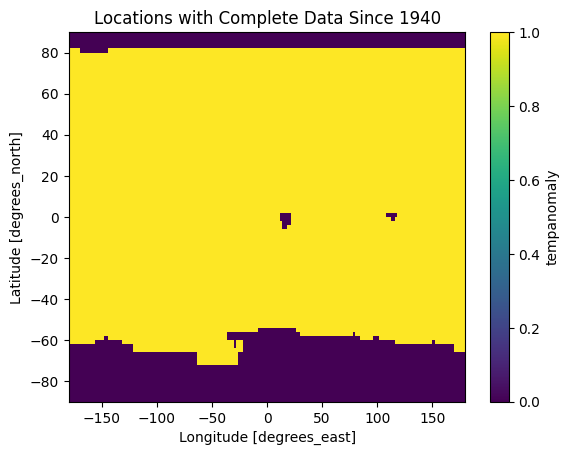

In [ ]:
complete_data = time_filtered.where(valid_locations)
valid_locations.plot(cmap="viridis")
plt.title("Locations with Complete Data Since 1940")
plt.show()

# ENSO region (lat = 0.0, lon = -150.0)

In [ ]:
# Re-load the dataset (replace 'your_dataset_path.nc' with the actual file path)
file_path = '/content/drive/MyDrive/2024-2025/time_series/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
ds = xr.open_dataset(file_path)

selected_lat = 0.0  # Latitude
selected_lon = -150.0  # Longitude

# Find the nearest point in the dataset
spot_data = ds['tempanomaly'].sel(lat=selected_lat, lon=selected_lon, method="nearest")

# Extract the time series as a 1D array
spot_data_1d = spot_data.values

# Create DataFrame for time series
spot_data_df = pd.DataFrame({
    "time": ds["time"].values,
    "temp_anomaly": spot_data_1d
})

# Filter the dataset to include only data from 1940 onward
filtered_spot_data_df = spot_data_df[spot_data_df['time'] >= '2018-01-01']

# Save the filtered dataset
filtered_output_csv_path = "/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_2018.csv"
filtered_spot_data_df.to_csv(filtered_output_csv_path, index=False)

print("Filtered dataset saved to:", filtered_output_csv_path)
print(filtered_spot_data_df.head(10))  # Preview first 10 rows

Filtered dataset saved to: /content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_2018.csv
           time  temp_anomaly
1656 2018-01-15         -0.95
1657 2018-02-15         -0.67
1658 2018-03-15         -0.60
1659 2018-04-15         -0.08
1660 2018-05-15          0.25
1661 2018-06-15          0.45
1662 2018-07-15          0.47
1663 2018-08-15          0.46
1664 2018-09-15          0.85
1665 2018-10-15          1.32


## train(1940-2023) test(2024)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_1940.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
len(train_data), len(test_data)

(1008, 10)

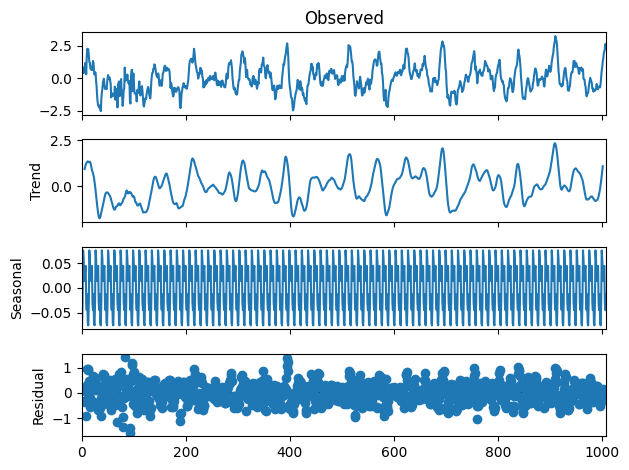

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(diff_series)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -7.47753346138066
p-value: 4.868877431406808e-11
Series is stationary.


#### Identifying $p, q$

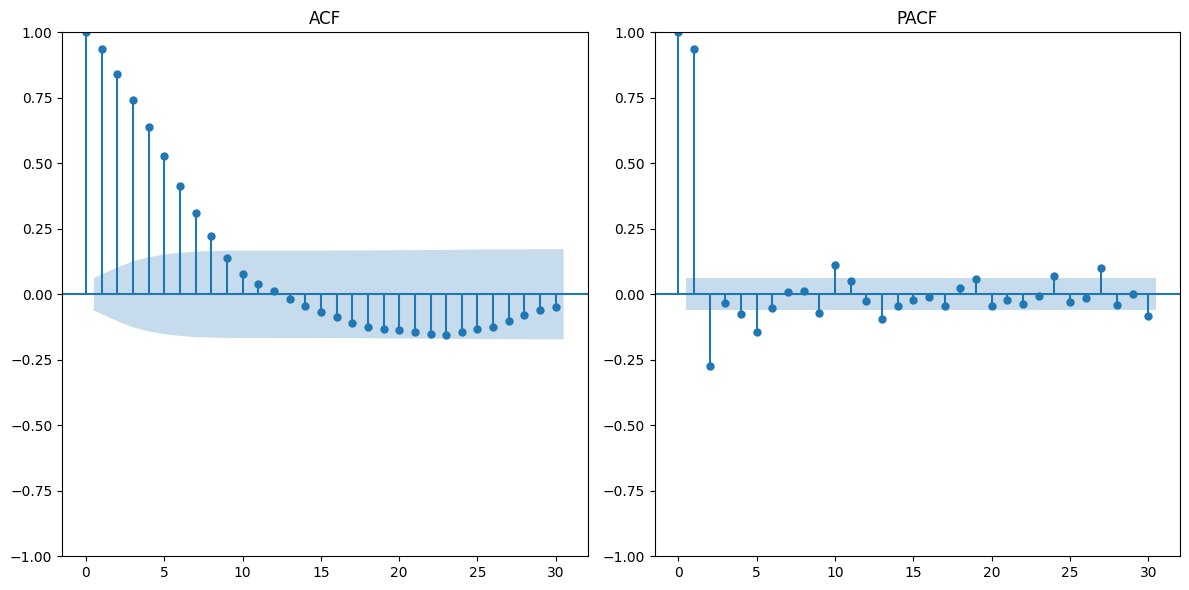

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.6067510122268523, 'MAPE': 247.94977205979202, 'RMSE': 0.6804033813991216, 'R^2': 0.19114253408200865, 'Model': 'ARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=14.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2878.252, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=749.941, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1876.199, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2876.606, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=748.456, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=749.938, Time=1.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=751.935, Time=1.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=667.888, Time=1.72 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=666.585, Time=4.46 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=667.942, Time=10.99 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=666.732, Time=11.87 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=666.760, Time=3.70 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=669.661, Time=16.99 sec
 ARIMA(3,0,0)(1,0,0)[12] inter

In [ ]:
print(auto_sarima)

 ARIMA(5,0,1)(1,0,0)[12]          


In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(steps=10)
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.32903399043353215, 'MAPE': 108.29383263086018, 'RMSE': 0.3529498959727248, 'R^2': 0.7823467339699957, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1998
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0377
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069
Epoch 16/20
32/32 ━━━━━━━━━━

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1591
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0221
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0146
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0078
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0061
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0068
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0058
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044
Epoch 16/20
32/32 ━━

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1203
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 16/20
32/32 ━━━━━━━━━━━━

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.606751  247.949772  0.680403  0.191143         ARIMA
1  0.329034  108.293833  0.352950  0.782347   AUTO-SARIMA
2  0.308096  126.671707  0.372014  0.758200          LSTM
3  0.218002   65.788806  0.252918  0.888237        BiLSTM
4  0.130238   33.096465  0.168725  0.950261           GRU


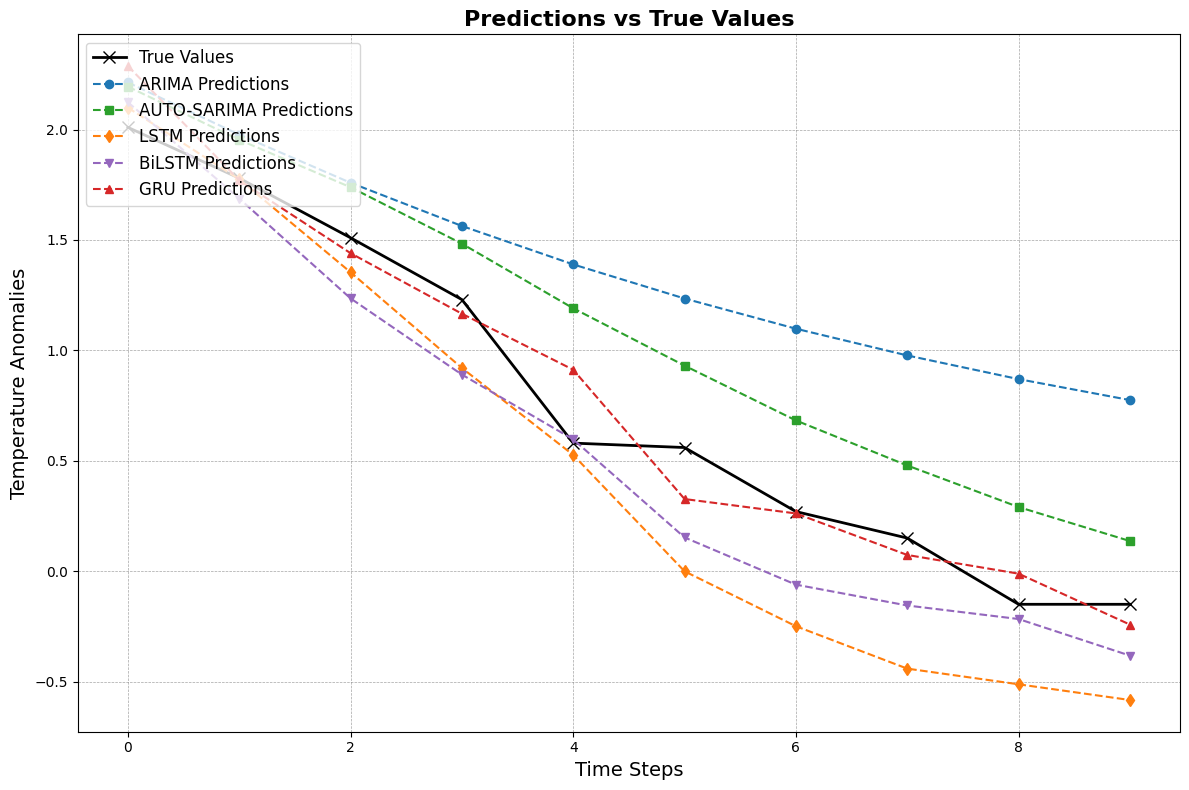

In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train(2010-2023) test(2024)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_2010.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
len(train_data), len(test_data)

(168, 10)

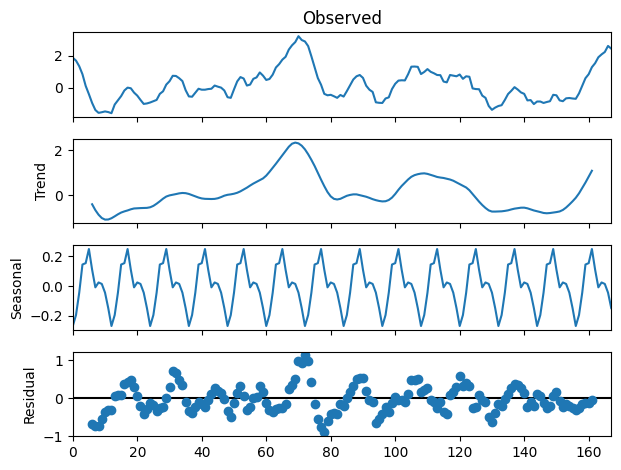

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(train_data)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -3.4964433270414204
p-value: 0.008078908167333487
Series is stationary.


#### Identifying $p, q$

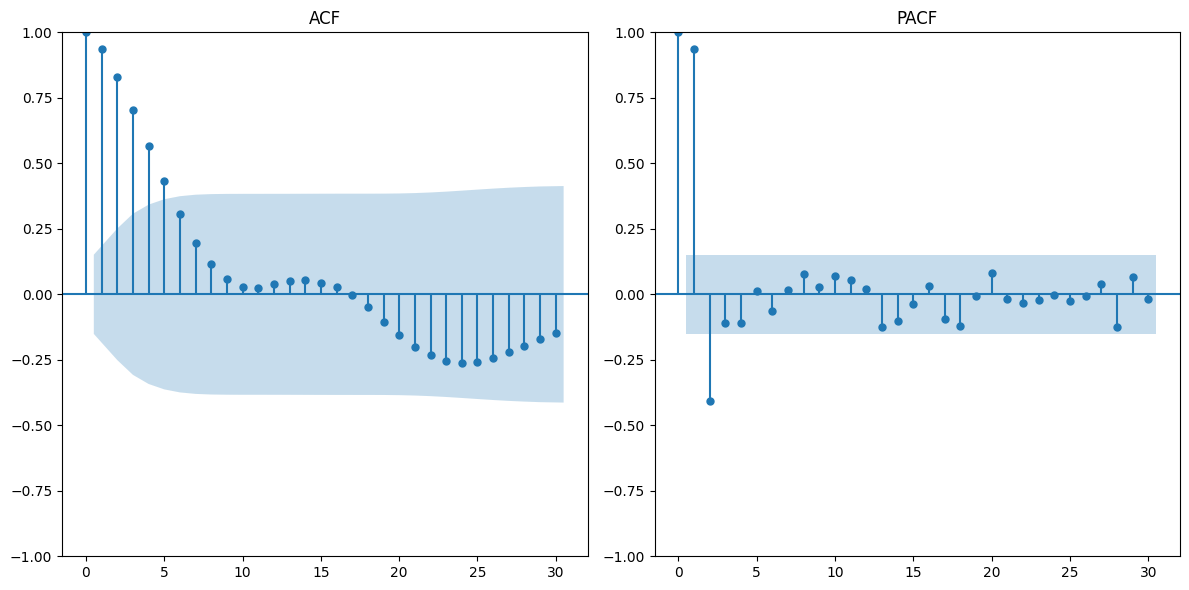

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.48311838573396493, 'RMSE': 0.538368071249058, 'R^2': 0.49359537562897216, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 0, 0), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=10)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  -6.240
Date:                              Sun, 08 Dec 2024   AIC                             22.479
Time:                                      16:55:12   BIC                             37.729
Sample:                                           0   HQIC                            28.673
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5761      0.061     25.707      0.000       1.456       1.696
ar.L2         -0.62

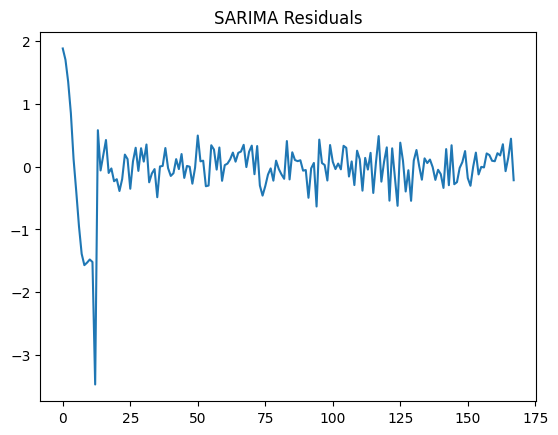

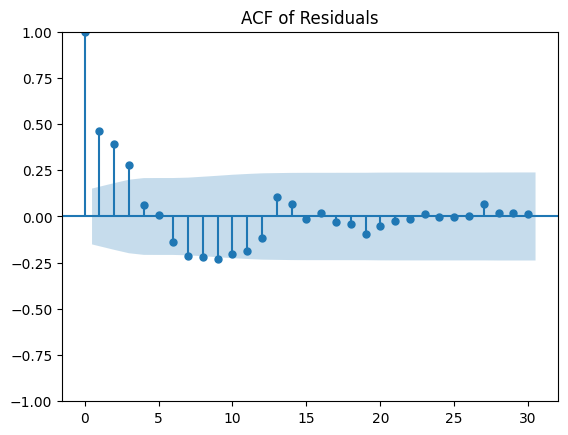

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.7981495068781843, 'MAPE': 305.28298655420184, 'RMSE': 0.8775779148243051, 'R^2': -0.3455828474500895, 'Model': 'SARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-0.279, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=491.731, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=72.283, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=299.362, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=494.793, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-2.269, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-0.512, Time=0.36 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-0.282, Time=4.62 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-2.222, Time=2.58 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1.722, Time=2.82 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=16.123, Time=0.49 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-3.664, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-2.146, Time=0.21 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-1.670, Time=0.88 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=-1

In [ ]:
print(auto_sarima)

 ARIMA(2,0,1)(1,0,0)[12]          


In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(steps=10)
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.25155045547704546, 'RMSE': 0.26889053899842663, 'R^2': 0.8736747648442234, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1777
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1296 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0849 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0635
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0325 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270  
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0214
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0218
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172  
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207  
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1536
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1246 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0863 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0686 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0324
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0365
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0285 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0259
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
{'MAE': 0.40387657194001764, 'MAPE': 134.57236375503325, 'RMSE': 0.45114012805852444, 'R^2': 0.6443998062463199, 'Model': 'BiLSTM'}


### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1095
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0735 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0585
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0296
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0218 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0183
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0195
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0098
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0097
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0091
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
{'MAE': 0.2482934640513191, 'MAPE': 68.475323628111, 'RMSE': 0.2797456639449304, 'R^2': 0.8632693748854453, 'Model': 'GRU'}


### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.483118  194.977045  0.538368  0.493595         ARIMA
1  0.251550   72.386201  0.268891  0.873675   AUTO-SARIMA
2  0.428465  154.044640  0.482945  0.592493          LSTM
3  0.403877  134.572364  0.451140  0.644400        BiLSTM
4  0.248293   68.475324  0.279746  0.863269           GRU


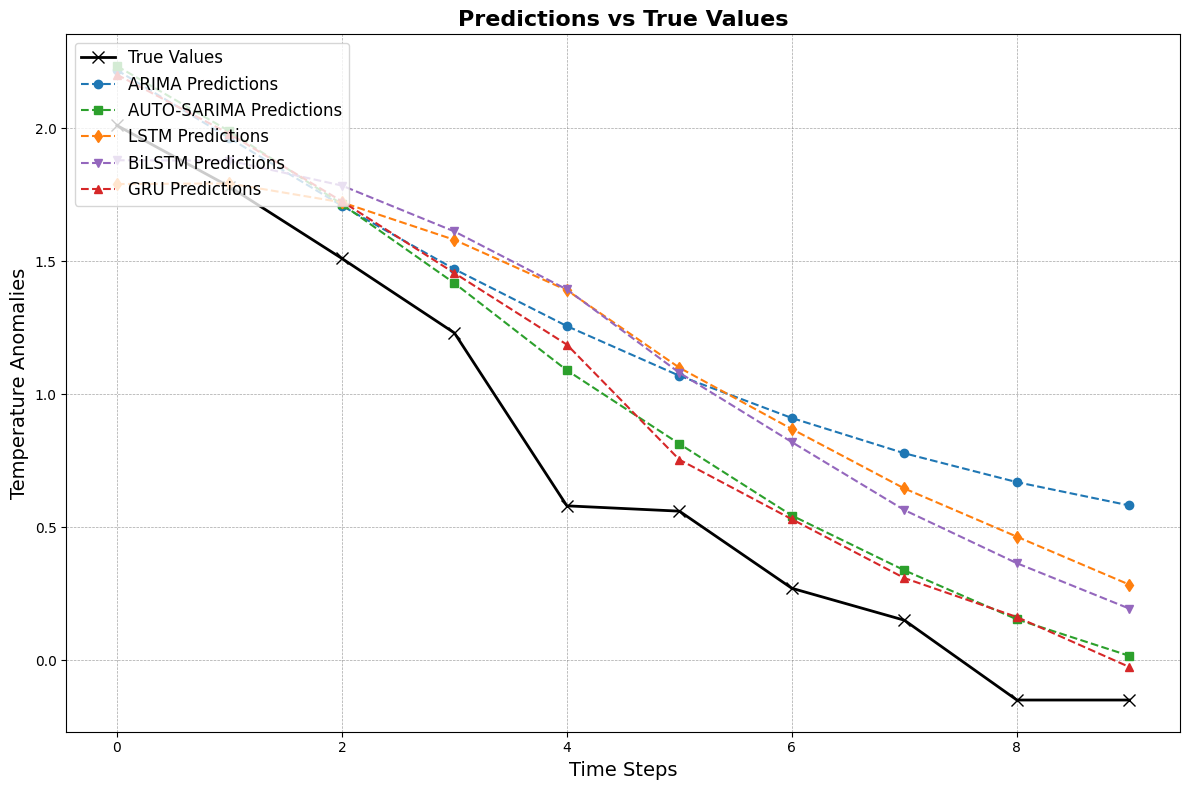

In [ ]:
# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train(2010-2022) test(2023-2024)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_2010.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-22)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
len(train_data), len(test_data)

(156, 22)

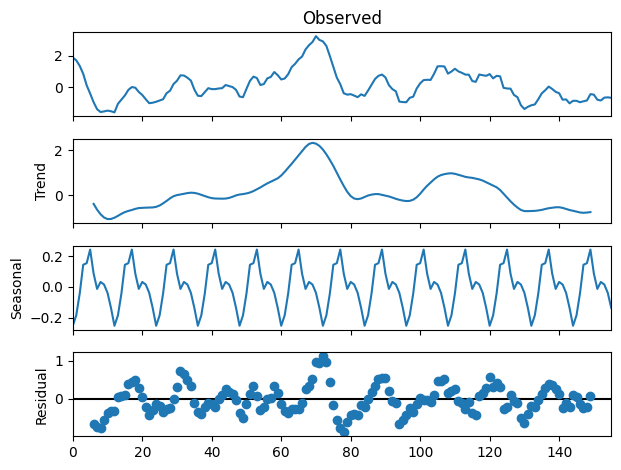

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(time_series)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")
    diff_series = time_series

ADF Statistic: -4.155949488049806
p-value: 0.0007816325399722831
Series is stationary.


In [ ]:
diff_series = np.diff(time_series, n=1)

# Recheck stationarity
result = adfuller(diff_series)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 0.006152074382231796


#### Identifying $p, q$

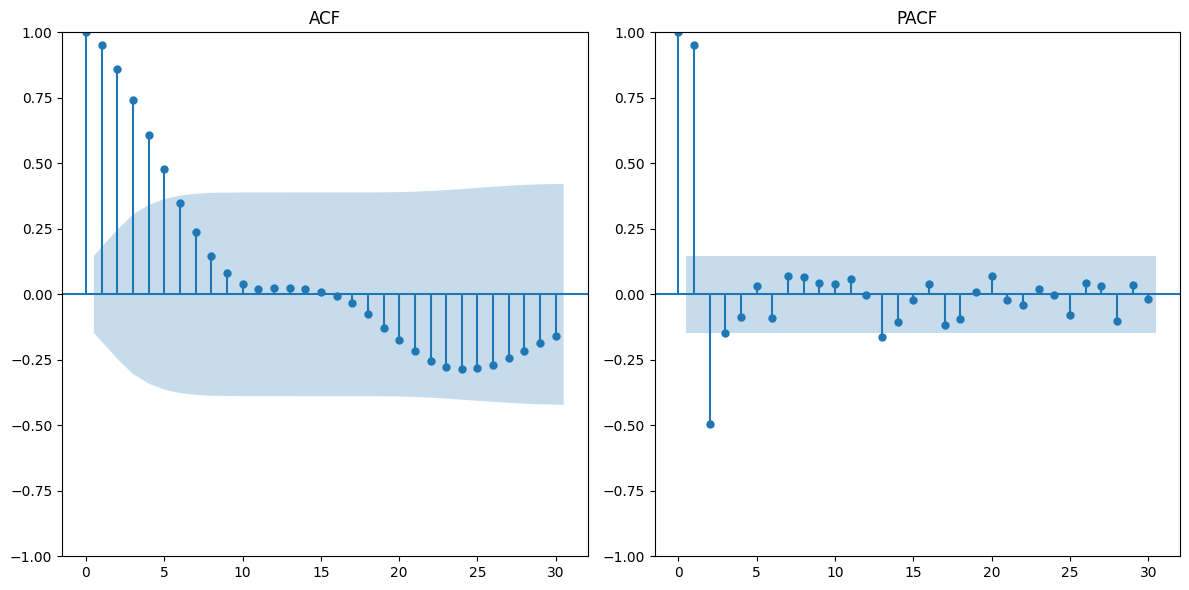

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 1.1471296765221406, 'MAPE': 115.08865302076332, 'RMSE': 1.413275518951554, 'R^2': -1.1459803246333968, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 0, 0), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=10)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  -6.240
Date:                              Sun, 08 Dec 2024   AIC                             22.479
Time:                                      16:55:12   BIC                             37.729
Sample:                                           0   HQIC                            28.673
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5761      0.061     25.707      0.000       1.456       1.696
ar.L2         -0.62

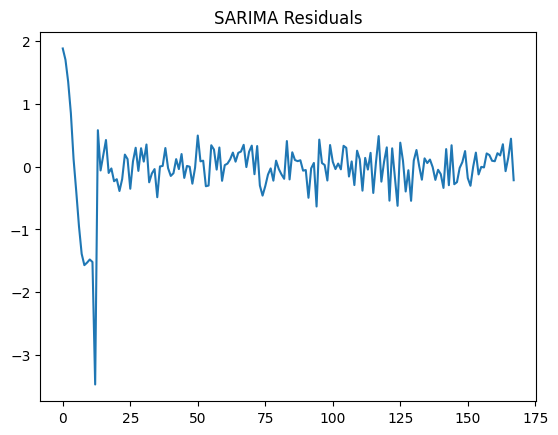

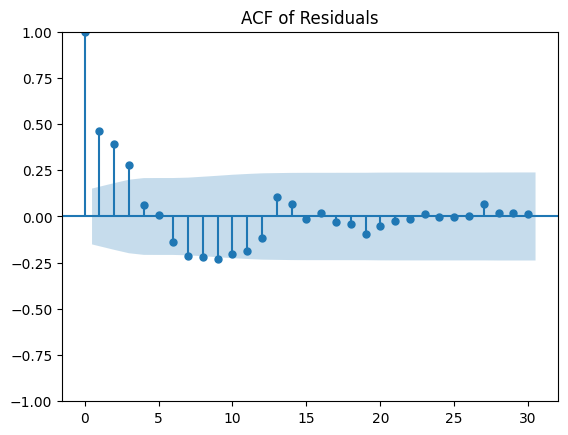

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.7981495068781843, 'MAPE': 305.28298655420184, 'RMSE': 0.8775779148243051, 'R^2': -0.3455828474500895, 'Model': 'SARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1.080, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=442.255, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=64.266, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=258.453, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=441.869, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-0.916, Time=1.78 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1.626, Time=4.15 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=1.080, Time=6.80 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-0.698, Time=5.66 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=3.079, Time=11.56 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=14.660, Time=1.57 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2.450, Time=1.25 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-0.152, Time=0.99 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-0.456, Time=3.65 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=-0.4

In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
print(len(auto_sarima_predictions))
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

22
{'MAE': 1.1734818275892318, 'MAPE': 114.22402633760423, 'RMSE': 1.4405534214093643, 'R^2': -1.229619737117857, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1981
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1461
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1055
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0677
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0442
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0307
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0244
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0252
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0245
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0241
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1119
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0774
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0397
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0340
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0361
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0310
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0281
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0255
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0270
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0267
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0248
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0248
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0212
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0216
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0213
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1489
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1137
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0752
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0509
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0276 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0178
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0141
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0111
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0112
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0090
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  1.147130  115.088653  1.413276 -1.145980         ARIMA
1  1.173482  114.224026  1.440553 -1.229620   AUTO-SARIMA
2  0.830839  140.527846  0.970236 -0.011409          LSTM
3  0.719152  109.999440  0.858678  0.207804        BiLSTM
4  0.441875   83.130403  0.496438  0.735209           GRU


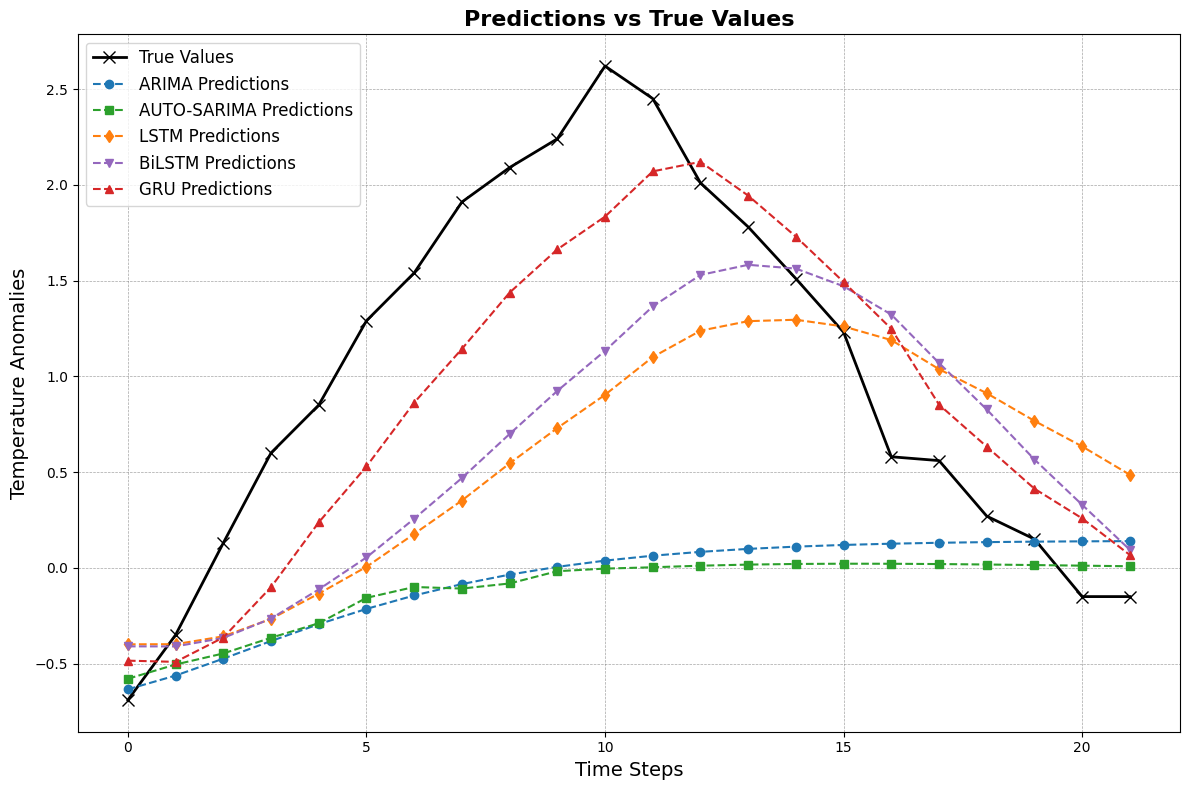

In [ ]:
# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train(1940-2022) test(2023-2024)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_1940.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-22)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
data

time  temp_anomaly
0     1940-01-15          0.72
1     1940-02-15          0.61
2     1940-03-15          0.88
3     1940-04-15          0.43
4     1940-05-15          0.69
...          ...           ...
1013  2024-06-15          0.56
1014  2024-07-15          0.27
1015  2024-08-15          0.15
1016  2024-09-15         -0.15
1017  2024-10-15         -0.15

[1018 rows x 2 columns]

In [ ]:
len(train_data), len(test_data)

(996, 22)

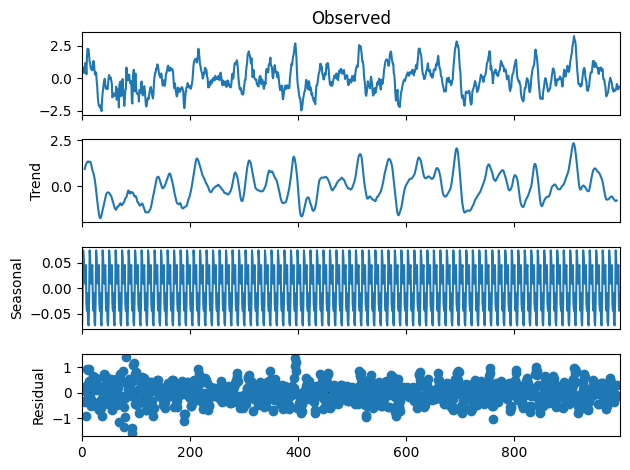

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(train_data)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -7.6206620778427885
p-value: 2.1328027785596997e-11
Series is stationary.


#### Identifying $p, q$

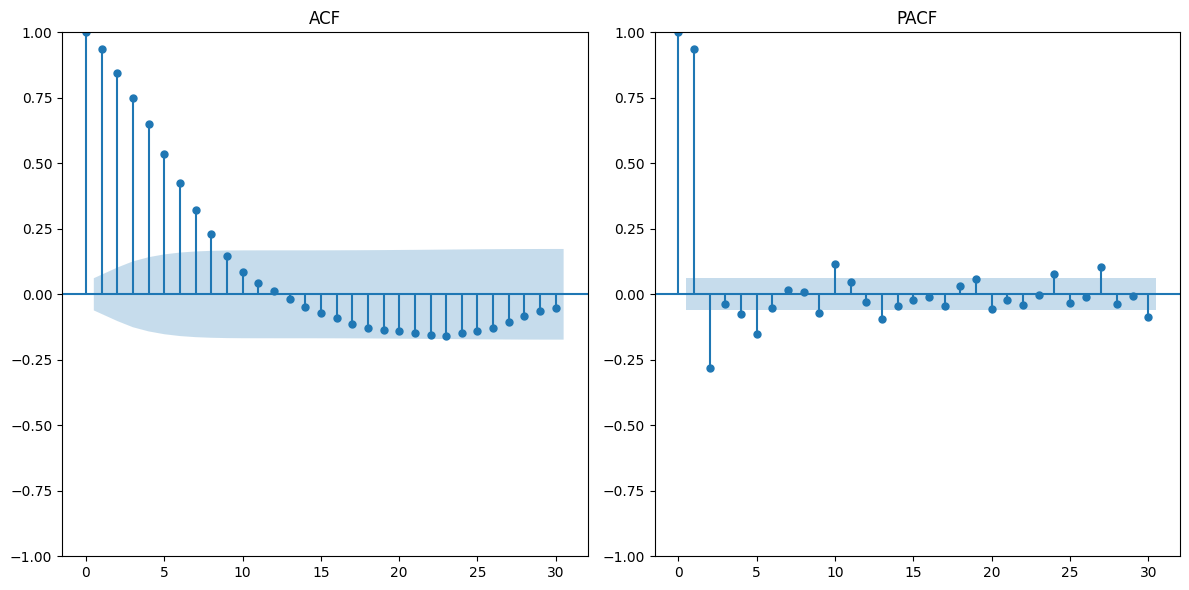

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 1.2736811763131244, 'MAPE': 123.55606575860725, 'RMSE': 1.5580827206635346, 'R^2': -1.608273242443103, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 0, 0), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=10)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  -6.240
Date:                              Sun, 08 Dec 2024   AIC                             22.479
Time:                                      16:55:12   BIC                             37.729
Sample:                                           0   HQIC                            28.673
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5761      0.061     25.707      0.000       1.456       1.696
ar.L2         -0.62

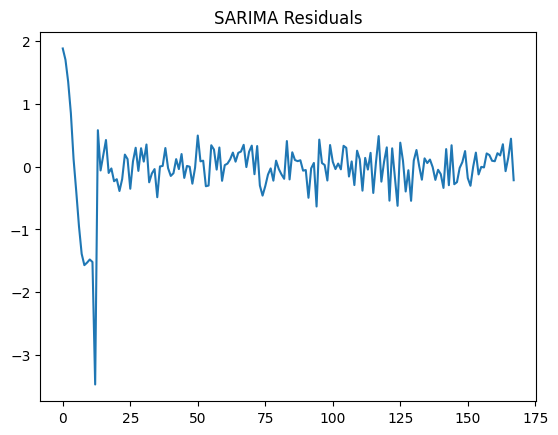

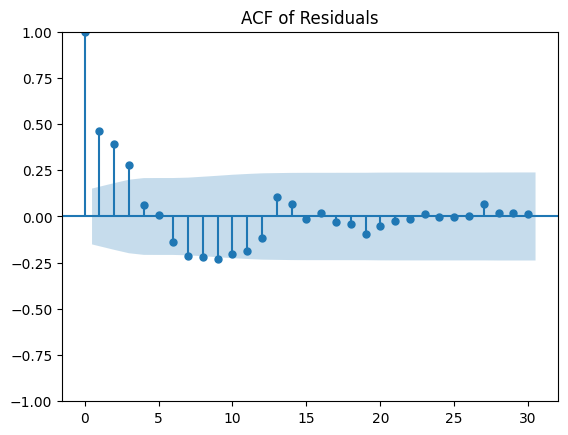

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.7981495068781843, 'MAPE': 305.28298655420184, 'RMSE': 0.8775779148243051, 'R^2': -0.3455828474500895, 'Model': 'SARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=660.956, Time=10.25 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2824.981, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=739.961, Time=2.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1837.115, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2823.000, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=641.052, Time=6.87 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=648.789, Time=3.83 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=641.719, Time=25.86 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=640.380, Time=15.18 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=641.833, Time=40.89 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=644.074, Time=25.57 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=665.058, Time=2.31 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=648.205, Time=3.65 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=650.944, Time=9.82 sec
 ARIMA(2,0,3)(1,0,0)[12] 

In [ ]:
print(auto_sarima)

 ARIMA(4,0,3)(0,0,0)[12]          


In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 1.154684140028072, 'MAPE': 109.7682468829866, 'RMSE': 1.4253989572090047, 'R^2': -1.1829557740671164, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2210
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0263
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0180
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0127
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0111
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0054
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056
Epoc

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0981
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0219
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0146
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0120
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0105
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0080
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0056
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'MAE': 0.2576476391052827, 'MAPE': 51.9777513005519, 'RMSE': 0.29448748791014195, 'R^2': 0.9068236361516773, 'Model': 'BiLSTM'}


### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1704
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0212
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0122
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0044
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043
Epoch 16/20
31/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
{'MAE': 0.23589691888745873, 'MAPE': 47.754402994216996, 'RMSE': 0.27586705080232216, 'R^2': 0.918234192952803, 'Model': 'GRU'}


### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  1.273681  123.556066  1.558083 -1.608273         ARIMA
1  1.154684  109.768247  1.425399 -1.182956   AUTO-SARIMA
2  0.264070   47.803201  0.317225  0.891880          LSTM
3  0.257648   51.977751  0.294487  0.906824        BiLSTM
4  0.235897   47.754403  0.275867  0.918234           GRU


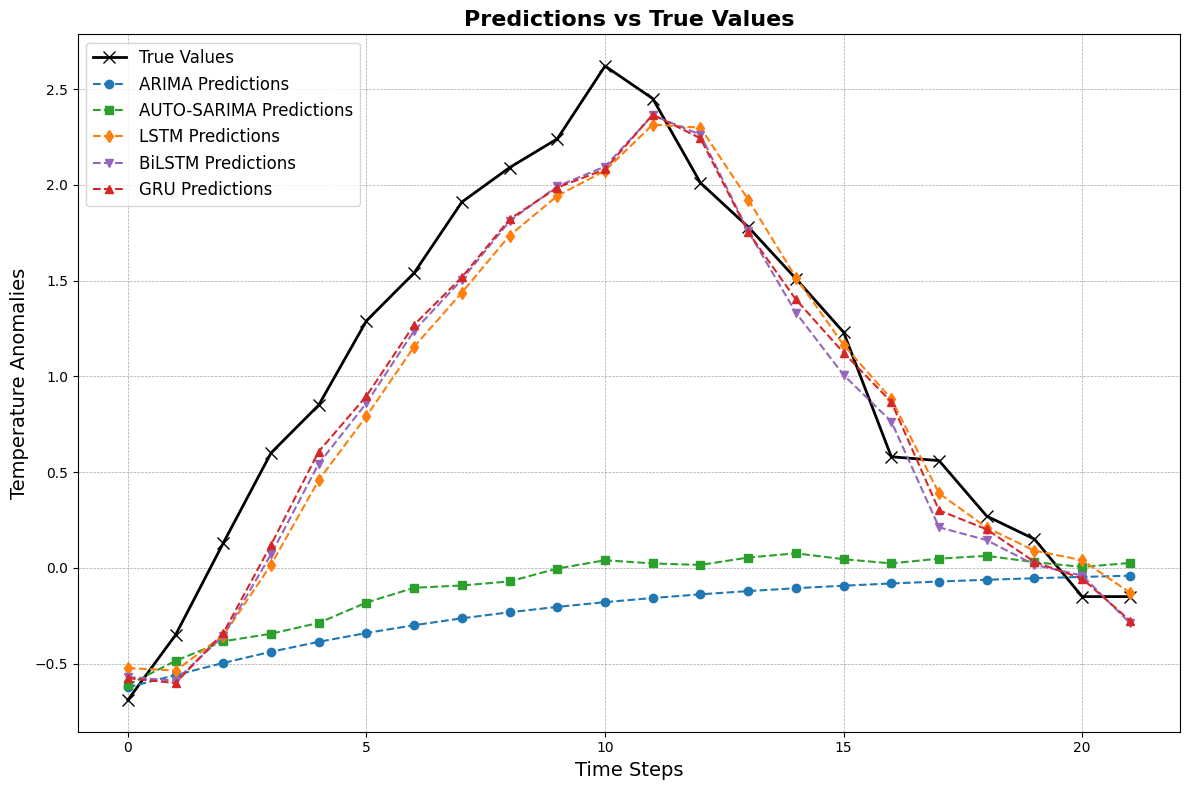

In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


# Western Indian Ocean (lat = 0.0, lon = 90.0)

In [ ]:
selected_lat = 0.0   # Latitude
selected_lon = 90.0  # Longitude

# Find the nearest point in the dataset to the selected latitude and longitude
spot_data = ds['tempanomaly'].sel(lat=selected_lat, lon=selected_lon, method="nearest")

# Extract the time series as a 1D array
spot_data_1d = spot_data.values

# Save the 1D time series for modeling
output_csv_path = "/content/drive/MyDrive/2024-2025/time_series/w_indian_ocean_tempanomaly.csv"
spot_data_df = pd.DataFrame({
    "time": ds["time"].values,
    "temp_anomaly": spot_data_1d
})
spot_data_df.to_csv(output_csv_path, index=False)

output_csv_path, spot_data_1d[:10]  # Return file path and preview of the first 10 values

('/content/drive/MyDrive/2024-2025/time_series/w_indian_ocean_tempanomaly.csv',
 array([-0.56      ,  0.17999999,  0.25      ,  0.09999999, -0.06      ,
        -0.08      , -0.32999998, -0.06      , -0.76      , -0.56      ],
       dtype=float32))

In [ ]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}

### train test split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/w_indian_ocean_tempanomaly.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")


ADF Statistic: -2.817095512604463
p-value: 0.055872984991950043
Series is non-stationary. Differencing is needed.


In [ ]:
diff_series = np.diff(train_data, n=1)

# Recheck stationarity
result = adfuller(diff_series)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 6.784631568415792e-23


#### Identifying $p, q$

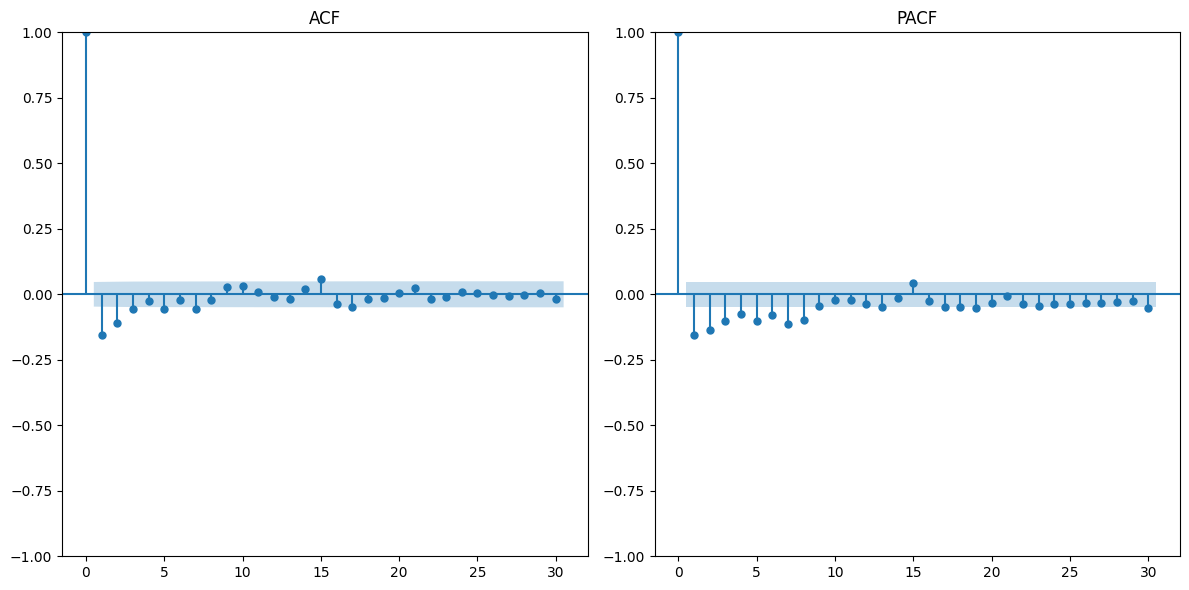

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Define parameter combinations
params = [(1, 1, 1), (2, 1, 1), (1, 1, 0)]

# Fit and compare models
aic_values = []
for p, d, q in params:
    model = ARIMA(time_series, order=(p, d, q))
    model_fit = model.fit()
    aic_values.append((p, d, q, model_fit.aic))
    print(f"ARIMA({p}, {d}, {q}) - AIC: {model_fit.aic}")

# Best parameters
best_model_params = sorted(aic_values, key=lambda x: x[3])[0]
print(f"Best ARIMA parameters: {best_model_params[:3]} with AIC: {best_model_params[3]}")


ARIMA(1, 1, 1) - AIC: -724.0040901665312
ARIMA(2, 1, 1) - AIC: -722.7945038120617
ARIMA(1, 1, 0) - AIC: -550.50992274908
Best ARIMA parameters: (1, 1, 1) with AIC: -724.0040901665312


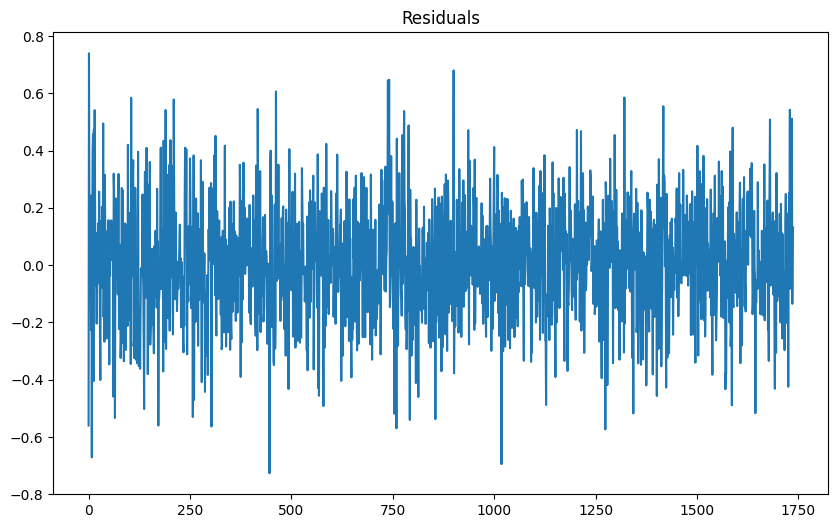

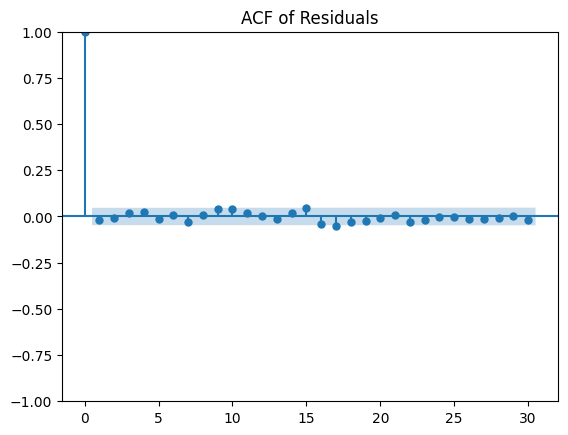

In [ ]:
best_model = ARIMA(time_series, order=(best_model_params[0], best_model_params[1], best_model_params[2])).fit()
residuals = best_model.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()


[1.2686906  1.18060426 1.11664217 1.0701974  1.03647249 1.01198383
 0.99420189 0.9812899  0.97191412 0.96510609 0.96016257 0.95657294]


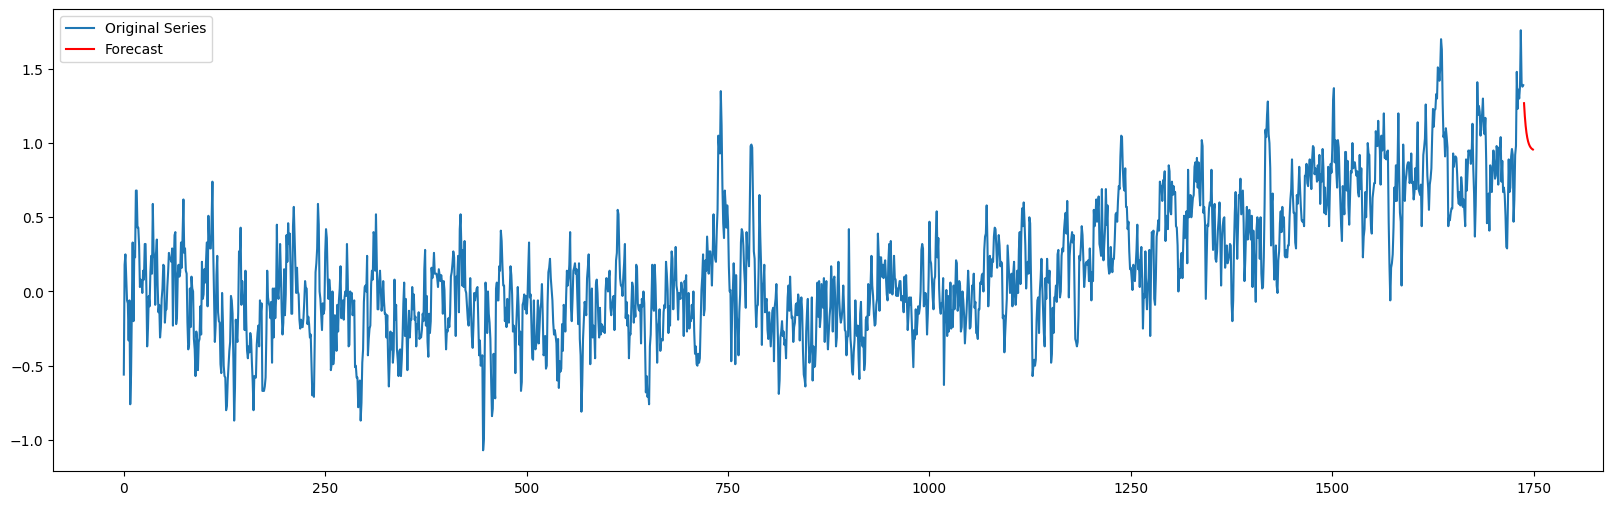

In [ ]:
forecast = best_model.forecast(steps=12)
print(forecast)

# Plot forecast
plt.figure(figsize=(20, 6))
plt.plot(time_series, label="Original Series")
plt.plot(range(len(time_series), len(time_series) + 12), forecast, label="Forecast", color="red")
plt.legend()
plt.show()


In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(1, 1, 1))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.5228159443759511, 'MAPE': 36.892859553169394, 'RMSE': 0.5594030897839227, 'R^2': -8.143635712489809, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=12)
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1738
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 357.079
Date:                            Sat, 07 Dec 2024   AIC                           -704.158
Time:                                    21:44:42   BIC                           -676.894
Sample:                                         0   HQIC                          -694.072
                                           - 1738                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7370      0.017     43.166      0.000       0.704       0.771
ma.L1         -0.9867      0.005   

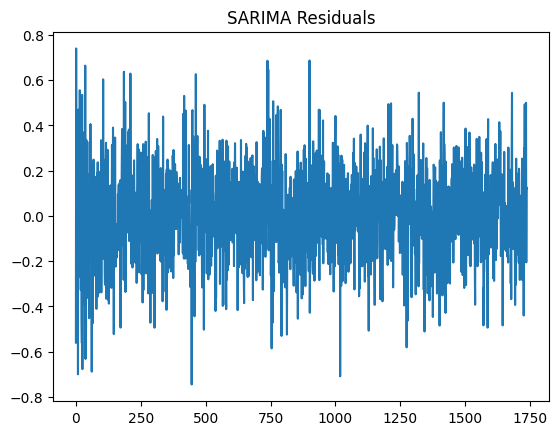

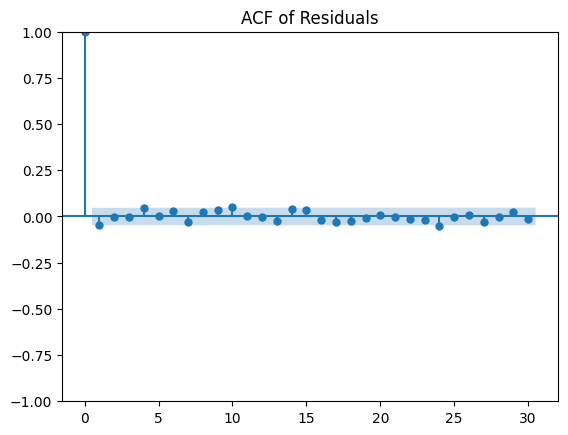

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.35247053190662136, 'MAPE': 25.526485099278197, 'RMSE': 0.3763962740575535, 'R^2': -3.139613789775624, 'Model': 'SARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(time_series, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-717.129, Time=16.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-508.909, Time=0.31 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-546.808, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-563.600, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-510.859, Time=0.24 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-719.131, Time=12.13 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-721.123, Time=2.66 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-719.035, Time=16.98 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-723.808, Time=2.17 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-721.821, Time=11.38 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-721.766, Time=7.58 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-718.064, Time=14.77 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-614.252, Time=2.77 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-724.800, Time=5.06 sec
 ARIMA(1,1,1)(

In [ ]:
auto_sarima_model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 12))
auto_sarima_model_fit = auto_sarima_model.fit()

auto_sarima_predictions = auto_sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.3640278503572687, 'MAPE': 26.07104248052938, 'RMSE': 0.39793619040291694, 'R^2': -3.6269634567649245, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1407
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0088
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0077
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0081
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0075
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0061
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054
Epoch 16

### HMM

In [ ]:
# Fit HMM
hmm = GaussianHMM(n_components=3, covariance_type='diag', n_iter=100)
hmm.fit(train_data.reshape(-1, 1))

# Predict and evaluate
hmm_predictions = hmm.sample(len(test_data))[0]
hmm_metrics = evaluate_model(test_data, hmm_predictions.flatten())
hmm_metrics['Model'] = 'HMM'
print(hmm_metrics)


{'MAE': 1.1847873072838488, 'MAPE': 87.60758331451098, 'RMSE': 1.2087611531604354, 'R^2': -41.69236189678956, 'Model': 'HMM'}


### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, sarima_metrics, auto_sarima_metrics, lstm_metrics, hmm_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE       MAPE      RMSE        R^2         Model
0  0.522816  36.892860  0.559403  -8.143636         ARIMA
1  0.352471  25.526485  0.376396  -3.139614        SARIMA
2  0.364028  26.071042  0.397936  -3.626963   AUTO-SARIMA
3  0.179105  12.510784  0.228452  -0.524966          LSTM
4  1.184787  87.607583  1.208761 -41.692362           HMM


# North Atlantic Ocean (lat = 50, lon = -35.0)

In [ ]:
# Re-load the dataset (replace 'your_dataset_path.nc' with the actual file path)
file_path = '/content/drive/MyDrive/2024-2025/time_series/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
ds = xr.open_dataset(file_path)

selected_lat = 50.0  # Latitude
selected_lon = -35.0  # Longitude

# Find the nearest point in the dataset
spot_data = ds['tempanomaly'].sel(lat=selected_lat, lon=selected_lon, method="nearest")

# Extract the time series as a 1D array
spot_data_1d = spot_data.values

# Create DataFrame for time series
spot_data_df = pd.DataFrame({
    "time": ds["time"].values,
    "temp_anomaly": spot_data_1d
})

# Filter the dataset to include only data from 1940 onward
filtered_spot_data_df = spot_data_df[spot_data_df['time'] >= '2010-01-01']

# Save the filtered dataset
filtered_output_csv_path = "/content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_2010.csv"
filtered_spot_data_df.to_csv(filtered_output_csv_path, index=False)

print("Filtered dataset saved to:", filtered_output_csv_path)
print(filtered_spot_data_df.head(10))  # Preview first 10 rows

Filtered dataset saved to: /content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_2010.csv
           time  temp_anomaly
1560 2010-01-15          0.26
1561 2010-02-15          0.28
1562 2010-03-15          0.28
1563 2010-04-15          0.55
1564 2010-05-15          1.43
1565 2010-06-15          0.94
1566 2010-07-15          0.15
1567 2010-08-15          1.70
1568 2010-09-15          1.37
1569 2010-10-15          0.54


In [ ]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}

## train (1940-2023) test (2024)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_1940.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")
    diff_series = train_data


ADF Statistic: -6.264726275350193
p-value: 4.140694928201999e-08
Series is stationary.


#### Identifying $p, q$

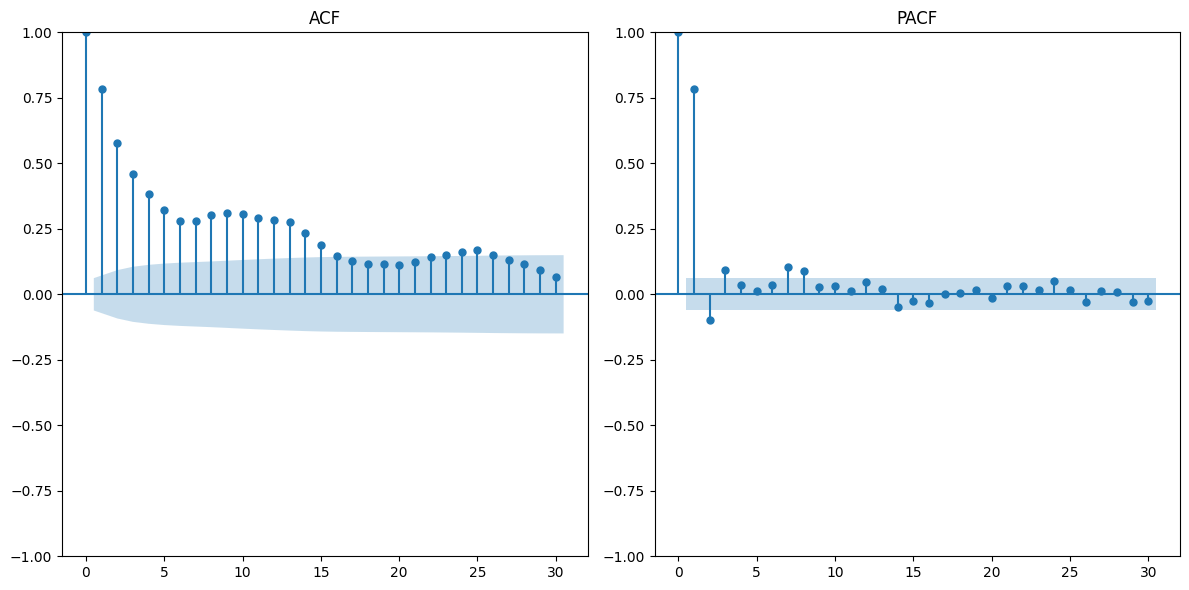

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.8744950739511932, 'MAPE': 96.4004767492736, 'RMSE': 1.0797074590664404, 'R^2': -0.5642416067165621, 'Model': 'ARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1357.038, Time=8.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1482.351, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1485.831, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1485.540, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1480.355, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1355.094, Time=14.98 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1353.545, Time=8.67 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1355.174, Time=6.18 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1351.575, Time=1.76 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1353.145, Time=5.52 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1353.153, Time=6.30 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1355.112, Time=7.84 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1421.402, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1370.417, Time=2.84 sec
 ARIMA(1,1,3)(0,0,

KeyboardInterrupt: 

In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train (2010-2023) test (2024)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_2010.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")


ADF Statistic: -2.5688502794546646
p-value: 0.09960768549120635
Series is non-stationary. Differencing is needed.


In [ ]:
diff_series = np.diff(train_data, n=1)

# Recheck stationarity
result = adfuller(diff_series)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 7.330402724410255e-16


#### Identifying $p, q$

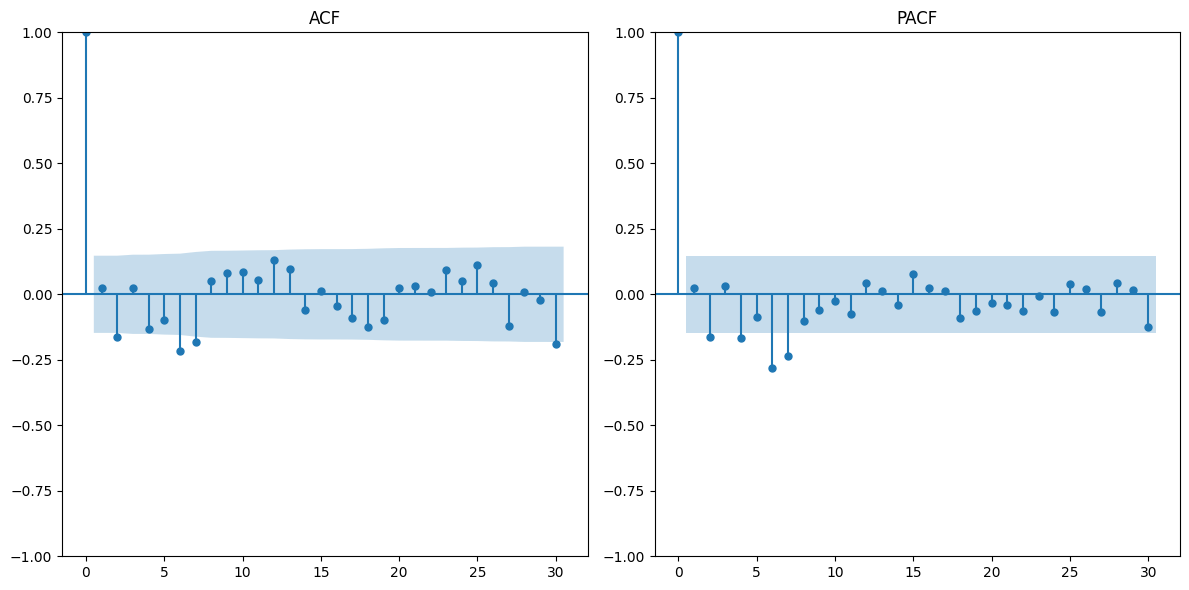

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(1, 1, 1))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.8971233706910182, 'MAPE': 107.4481868478516, 'RMSE': 1.089883036848407, 'R^2': -0.593864568488494, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(2, 1, 2), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=12)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1738
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1237.562
Date:                              Wed, 04 Dec 2024   AIC                           2489.125
Time:                                      02:50:08   BIC                           2527.295
Sample:                                           0   HQIC                          2503.245
                                             - 1738                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4198      0.167      2.521      0.012       0.093       0.746
ar.L2          0.07

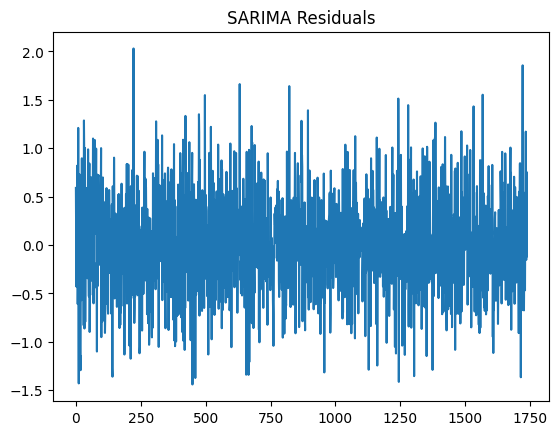

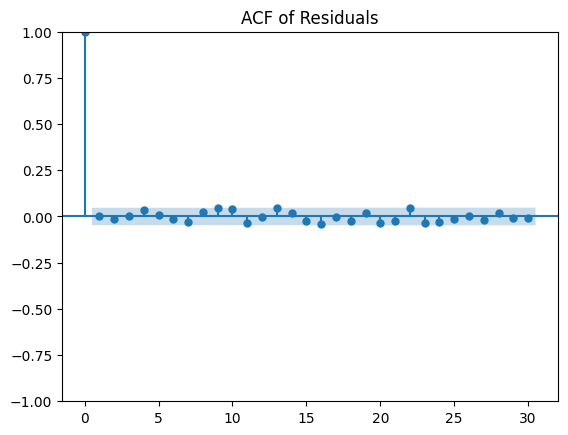

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.9560475927085441, 'MAPE': inf, 'RMSE': 1.171538683366706, 'R^2': -1.245213878016425, 'Model': 'SARIMA'}


<ipython-input-66-a3f87794642b>:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(time_series, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=440.272, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=272.736, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=309.276, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=439.579, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=276.545, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=273.742, Time=0.79 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=273.531, Time=0.58 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=8.20 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=415.007, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=271.488, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=274.377, Time=0.07 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=273.087, Time=0.83 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=in

In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.7975299567987353, 'MAPE': 88.72676716947694, 'RMSE': 0.9789869913867755, 'R^2': -0.28601333533452955, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2538
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2107 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1783 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1507  
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1120 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1041  
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0649  
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0446 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333  
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0303  
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0301 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0323 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1932
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1358 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0929
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0514 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0370
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0305 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0343  
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0338 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0325 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0295 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0299
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0298
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0273 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1796
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1406
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1140
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0887
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0592
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0476
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0323  
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0295
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0252
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0255  
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.897123  107.448187  1.089883 -0.593865         ARIMA
1  0.797530   88.726767  0.978987 -0.286013   AUTO-SARIMA
2  0.908746  182.861936  0.995478 -0.329704          LSTM
3  0.883712  179.237965  0.968503 -0.258617        BiLSTM
4  0.704263  105.443683  0.845542  0.040683           GRU


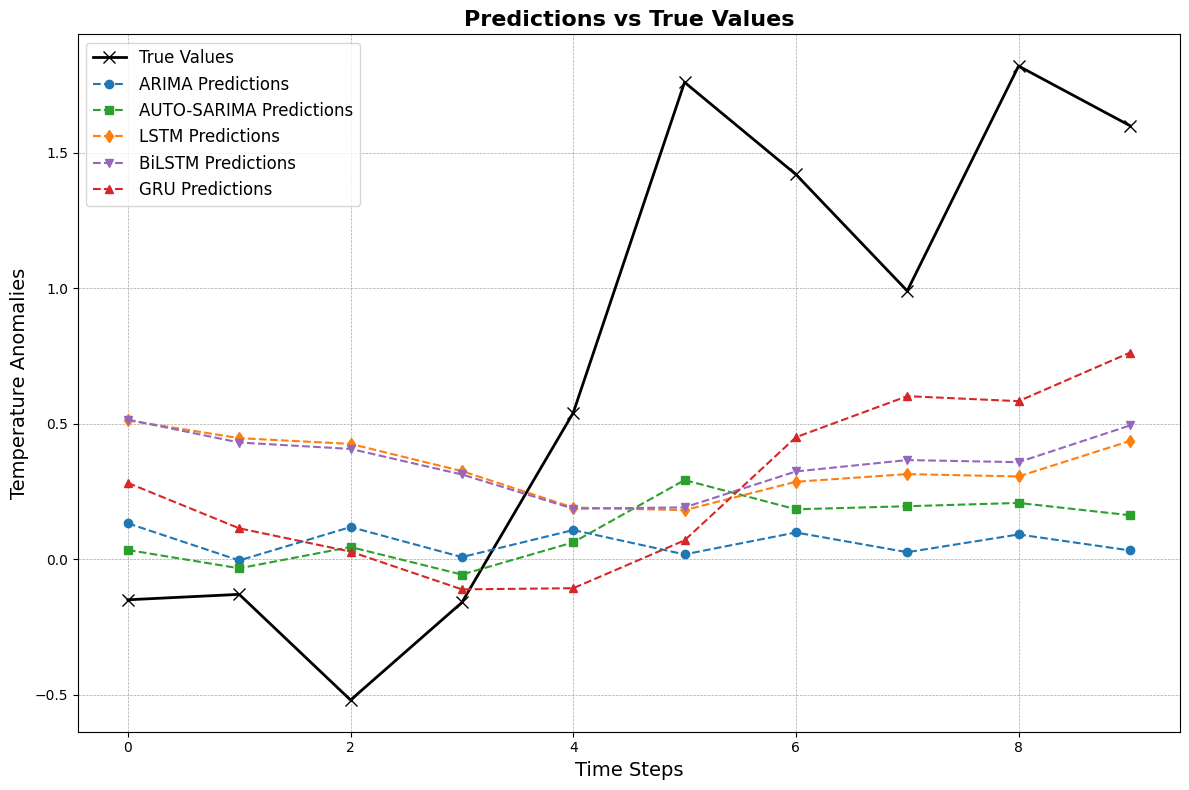

In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train (1940-2022) test (2023-2024)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_1940.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-22)
train_data, test_data = time_series[:split_index], time_series[split_index:]

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")


ADF Statistic: -6.297112601734509
p-value: 3.4840042677321274e-08
Series is stationary.


#### Identifying $p, q$

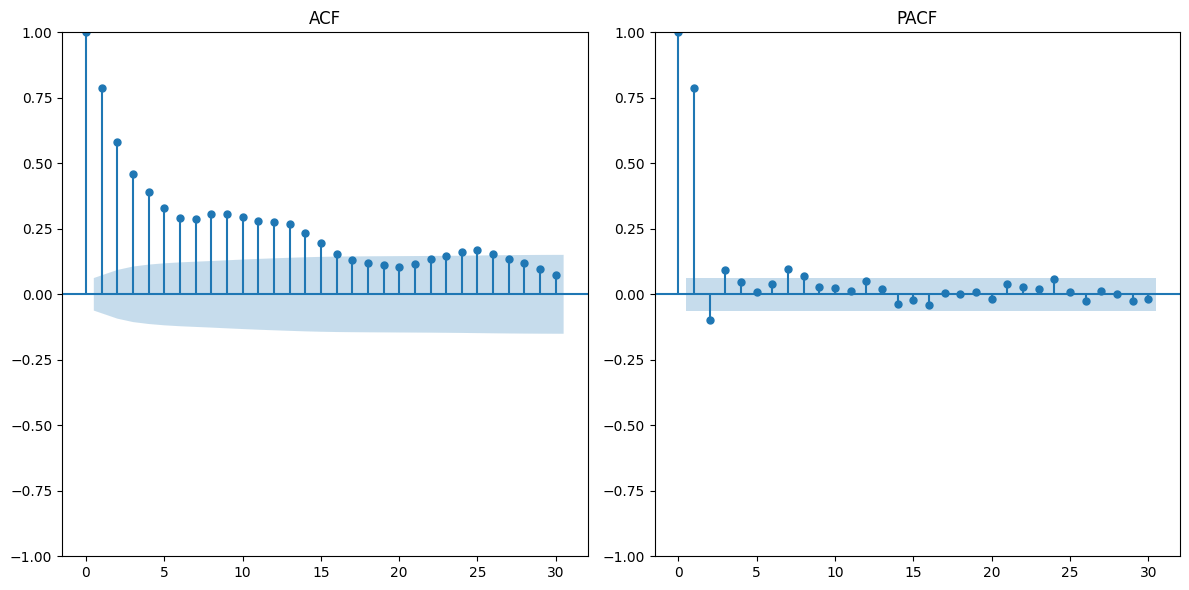

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(train_data, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(train_data, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.8603593102525084, 'MAPE': 121.06230027021047, 'RMSE': 1.0889553383755468, 'R^2': -0.5453813800766976, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(2, 1, 2), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=12)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1738
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1237.562
Date:                              Wed, 04 Dec 2024   AIC                           2489.125
Time:                                      02:50:08   BIC                           2527.295
Sample:                                           0   HQIC                          2503.245
                                             - 1738                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4198      0.167      2.521      0.012       0.093       0.746
ar.L2          0.07

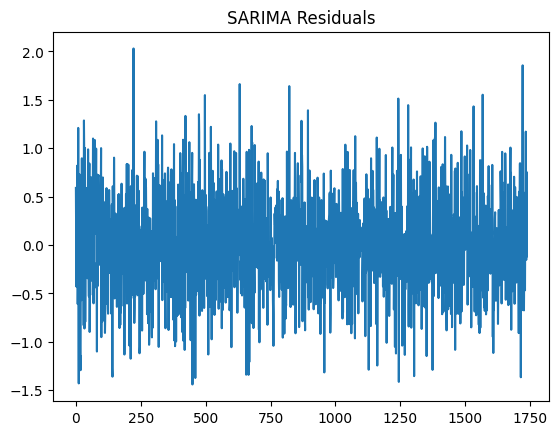

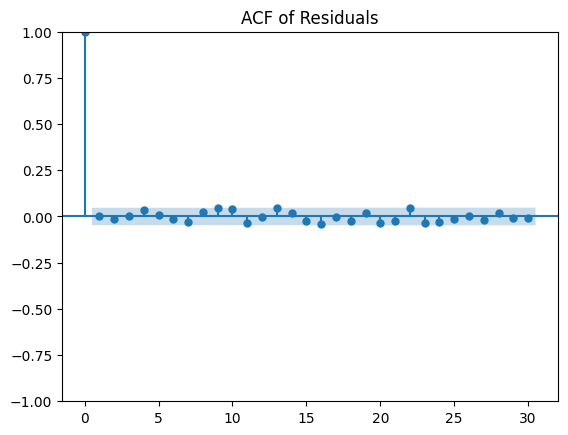

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.9560475927085441, 'MAPE': inf, 'RMSE': 1.171538683366706, 'R^2': -1.245213878016425, 'Model': 'SARIMA'}


<ipython-input-66-a3f87794642b>:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1324.894, Time=8.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1447.846, Time=0.37 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1451.426, Time=1.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1451.165, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1445.850, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1322.974, Time=5.85 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1321.272, Time=2.47 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1323.965, Time=17.66 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1319.279, Time=7.30 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1320.983, Time=13.16 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1320.993, Time=4.85 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1322.921, Time=6.42 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1386.674, Time=1.25 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1337.577, Time=3.60 sec
 ARIMA(1,1,3)(0,0

In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.8021819725569077, 'MAPE': 188.30734194902604, 'RMSE': 0.9726775912089438, 'R^2': -0.23297241369864086, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1581
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0172
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0171
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0152
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0146
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0124
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0136
Epoch 16/20
31/

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1707
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0197
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0189
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0171
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0175
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0175
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0168
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0149
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0163
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0150
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0150
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0142
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0143
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0131
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0122
Epoch 16/20
31/

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0954
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0173
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0131
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0127
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0116
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0113
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0104
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0108
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0098
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0106
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0096
Epoch 16/20
31/

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.860359  121.062300  1.088955 -0.545381         ARIMA
1  0.802182  188.307342  0.972678 -0.232972   AUTO-SARIMA
2  0.579261  228.693482  0.756542  0.254098          LSTM
3  0.498455  146.678625  0.705955  0.350515        BiLSTM
4  0.496904  129.088827  0.689457  0.380516           GRU


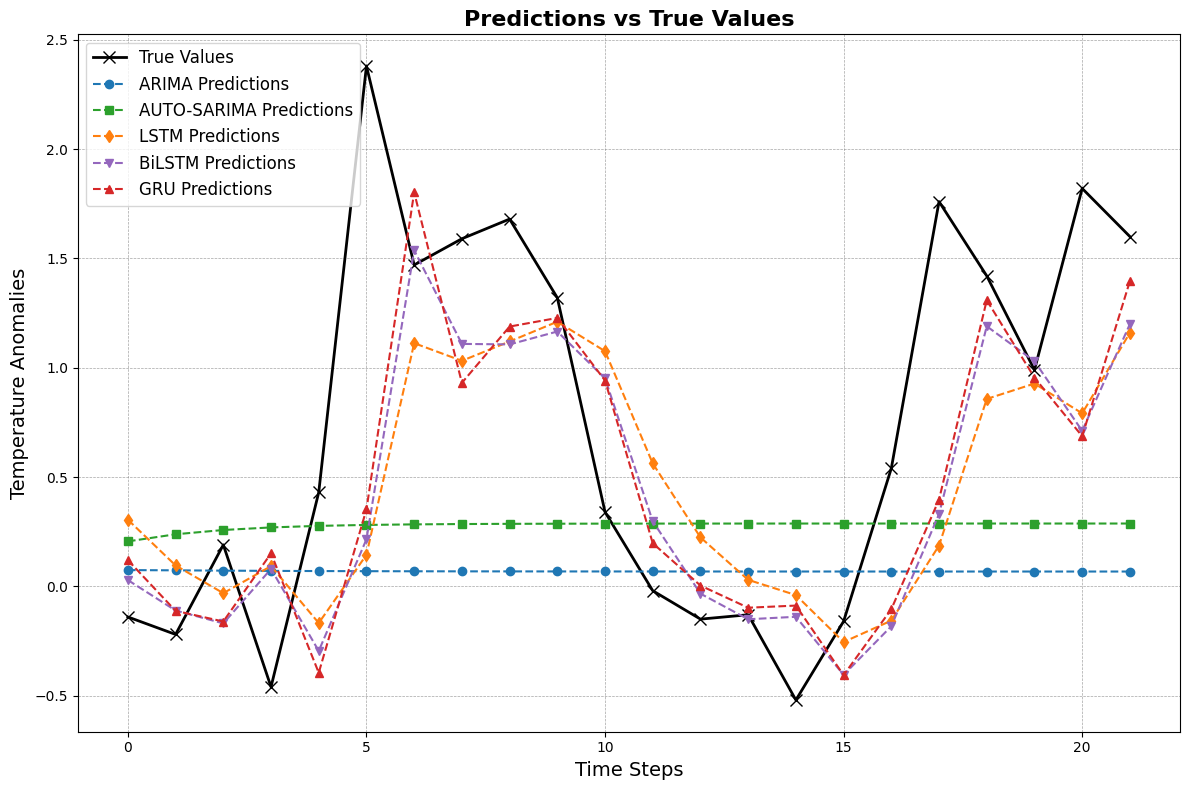

In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## train (2010-2022) test (2023-2024)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/n_atlantic_ocean_from_2010.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-22)
train_data, test_data = time_series[:split_index], time_series[split_index:]

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
else:
    print("Series is stationary.")


ADF Statistic: -4.873889481989638
p-value: 3.9193778284215424e-05
Series is stationary.


In [ ]:
diff_series = np.diff(train_data, n=1)

# Recheck stationarity
result = adfuller(diff_series)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 7.330402724410255e-16


#### Identifying $p, q$

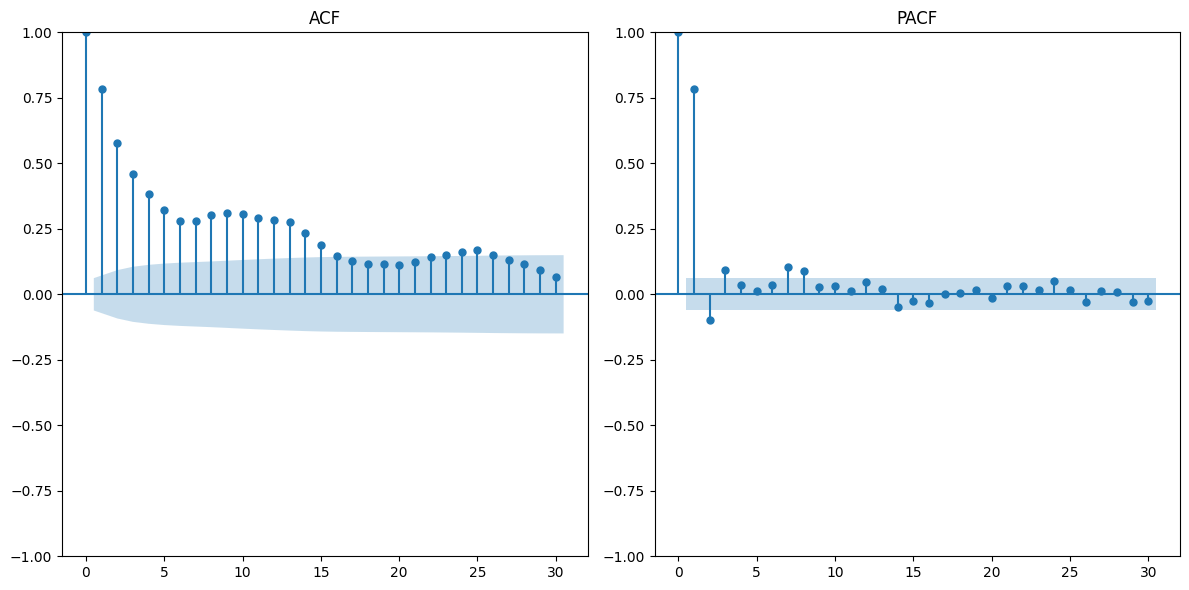

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.8860290383698323, 'MAPE': 98.0815078122602, 'RMSE': 1.139393711330236, 'R^2': -0.6918551391067664, 'Model': 'ARIMA'}


### SARIMA

In [ ]:
# Define seasonal order (P, D, Q, m)
seasonal_order = (1, 1, 1, 12) # 12 for monthly data

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(2, 1, 2), seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Print summary
print(sarima_model_fit.summary())

# Forecast
forecast = sarima_model_fit.forecast(steps=12)
print(forecast)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1738
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1237.562
Date:                              Wed, 04 Dec 2024   AIC                           2489.125
Time:                                      02:50:08   BIC                           2527.295
Sample:                                           0   HQIC                          2503.245
                                             - 1738                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4198      0.167      2.521      0.012       0.093       0.746
ar.L2          0.07

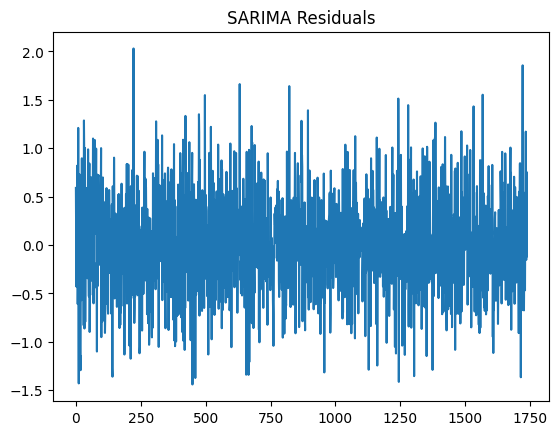

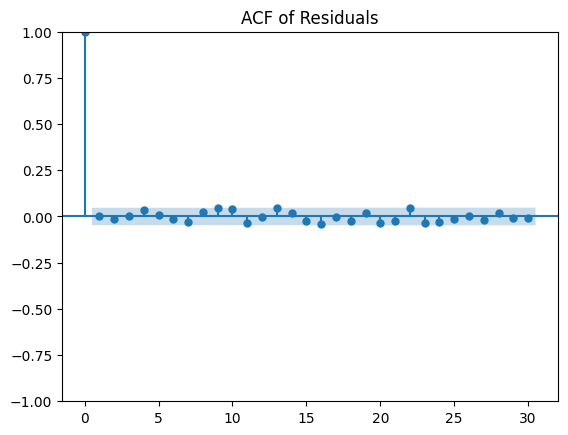

In [ ]:
residuals = sarima_model_fit.resid

plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
# Predict on the test set
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate SARIMA model
sarima_metrics = evaluate_model(test_data, sarima_predictions)
sarima_metrics['Model'] = 'SARIMA'
print(sarima_metrics)

{'MAE': 0.9560475927085441, 'MAPE': inf, 'RMSE': 1.171538683366706, 'R^2': -1.245213878016425, 'Model': 'SARIMA'}


<ipython-input-66-a3f87794642b>:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(time_series, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=440.272, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=272.736, Time=1.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=309.276, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=439.579, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=276.545, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=273.742, Time=3.80 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.65 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=273.531, Time=0.49 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=415.007, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=271.488, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=274.377, Time=0.08 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=273.087, Time=0.85 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=in

In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.8372410449440398, 'MAPE': 102.87991178443974, 'RMSE': 1.0727112735044122, 'R^2': -0.49962001527147737, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1709
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1392
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0747
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0346
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0306
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0288 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0306
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0270
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0269
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0274
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1948
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1231
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0812
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0395
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0350
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0461
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0291
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0334
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0320
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0342
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0309
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0317
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0315
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0291
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0346
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1580
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1320
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0930
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0591
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0435
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0286
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0267
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0231
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0244
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0264
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0214
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.886029   98.081508  1.139394 -0.691855         ARIMA
1  0.837241  102.879912  1.072711 -0.499620   AUTO-SARIMA
2  0.794843  270.039190  0.932721 -0.133754          LSTM
3  0.798996  269.710804  0.927300 -0.120614        BiLSTM
4  0.695119  221.727111  0.859756  0.036689           GRU


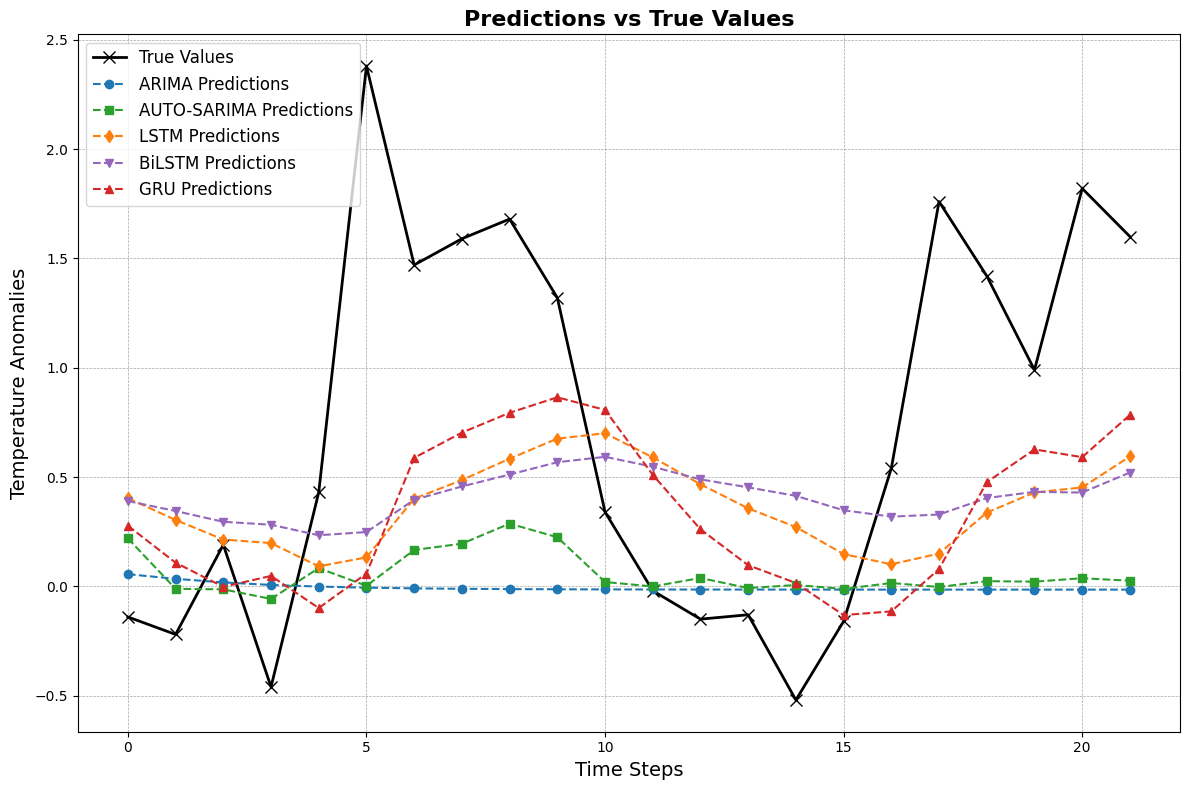

In [ ]:
import matplotlib.pyplot as plt

# Plot true values and predictions
plt.figure(figsize=(12, 8))  # Larger figure for better readability

# True values
plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# Predictions
plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
plt.plot(gru_predictions, label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)

# Labels and Title
plt.title("Predictions vs True Values", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## ENSO trial

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly_from_2010.csv')
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-22)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [ ]:
len(train_data), len(test_data)

(156, 22)

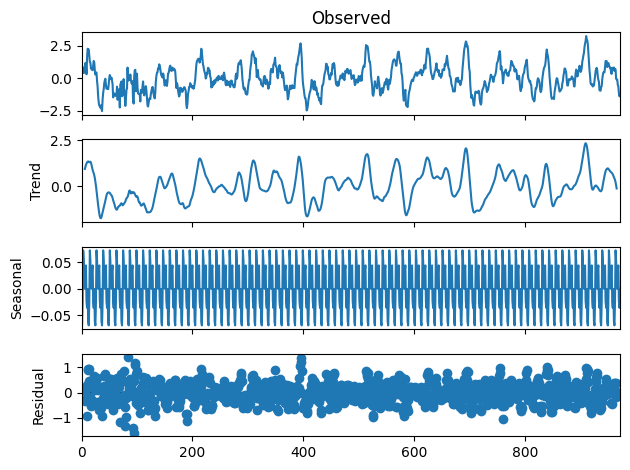

In [ ]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [ ]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(diff_series)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -7.413632403146902
p-value: 7.027829128524454e-11
Series is stationary.


#### Identifying $p, q$

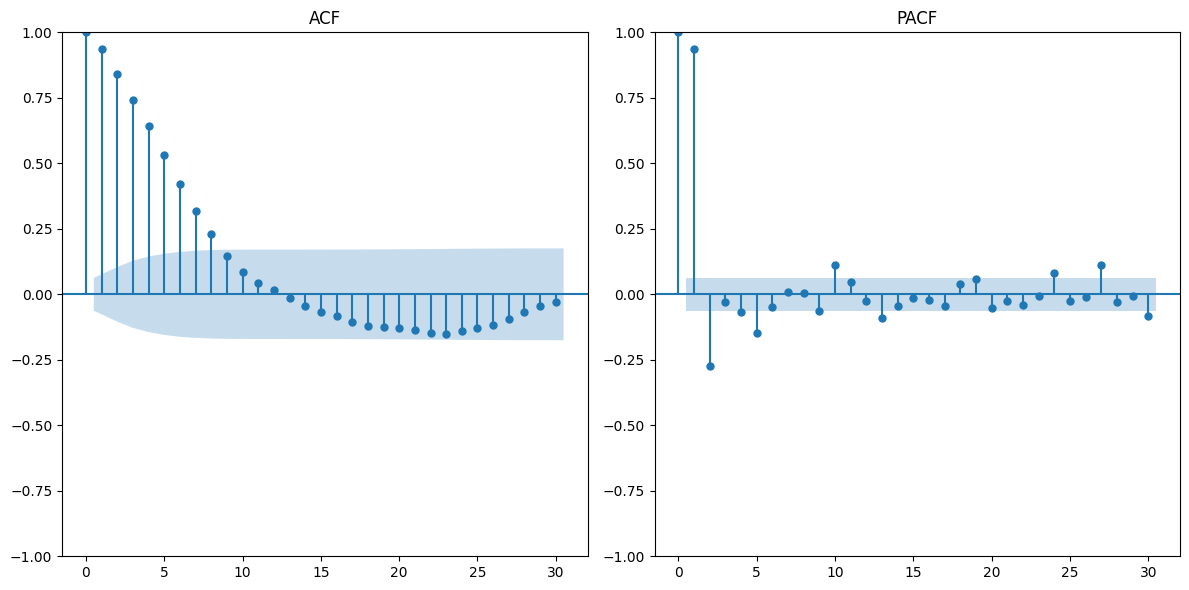

In [ ]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.7946402194391533, 'MAPE': 124.95807437728827, 'RMSE': 1.0446821961169594, 'R^2': 0.08937698105715419, 'Model': 'ARIMA'}


### Auto-SARIMA

In [ ]:
auto_sarima = auto_arima(train_data, seasonal=True, m=29, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[29] intercept   : AIC=704.447, Time=41.66 sec
 ARIMA(0,1,0)(0,0,0)[29] intercept   : AIC=763.839, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[29] intercept   : AIC=702.021, Time=2.92 sec
 ARIMA(0,1,1)(0,0,1)[29] intercept   : AIC=701.935, Time=4.49 sec
 ARIMA(0,1,0)(0,0,0)[29]             : AIC=761.870, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[29] intercept   : AIC=710.915, Time=0.69 sec
 ARIMA(0,1,1)(1,0,1)[29] intercept   : AIC=702.986, Time=4.97 sec
 ARIMA(0,1,1)(0,0,2)[29] intercept   : AIC=703.473, Time=13.15 sec
 ARIMA(0,1,1)(1,0,0)[29] intercept   : AIC=702.502, Time=3.03 sec
 ARIMA(0,1,1)(1,0,2)[29] intercept   : AIC=inf, Time=31.47 sec
 ARIMA(0,1,0)(0,0,1)[29] intercept   : AIC=757.766, Time=2.05 sec
 ARIMA(1,1,1)(0,0,1)[29] intercept   : AIC=702.670, Time=5.87 sec
 ARIMA(0,1,2)(0,0,1)[29] intercept   : AIC=702.635, Time=3.88 sec
 ARIMA(1,1,0)(0,0,1)[29] intercept   : AIC=701.286, Time=2.18 sec
 ARIMA(1,1,0)(0,0,0)[29] intercept

In [ ]:
print(auto_sarima)

 ARIMA(1,1,0)(0,0,1)[29]          


In [ ]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(n_periods=len(test_data))
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 1.38170248276578, 'RMSE': 1.8178195097960401, 'R^2': -1.7572221453324257, 'Model': ' AUTO-SARIMA'}


### LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.1100
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0211
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0156
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0131
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0114
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0093
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0077
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0073
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0059
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0055
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0048
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057
Epoc

### BiLSTM

In [ ]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1104
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0244
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0193
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0170
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0131
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0117
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0095
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0086
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0089
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0066
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0058
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0072
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0058
Epoch 16/20
29/

### GRU

In [ ]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1303
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0094
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0078
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0058
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0052
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0046
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0042
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0040
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0042
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039
Epoch 16/20
29/

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
{'MAE': 0.18775442361915298, 'MAPE': 43.787536636160816, 'RMSE': 0.231047533452434, 'R^2': 0.955457672092515, 'Model': 'GRU'}


### Eval Results

In [ ]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE        MAPE      RMSE       R^2         Model
0  0.794640  124.958074  1.044682  0.089377         ARIMA
1  1.449365  317.413355  1.839861 -1.824492   AUTO-SARIMA
2  0.216624   47.581539  0.265155  0.941336          LSTM
3  0.227714   56.023254  0.282872  0.933235        BiLSTM
4  0.187754   43.787537  0.231048  0.955458           GRU


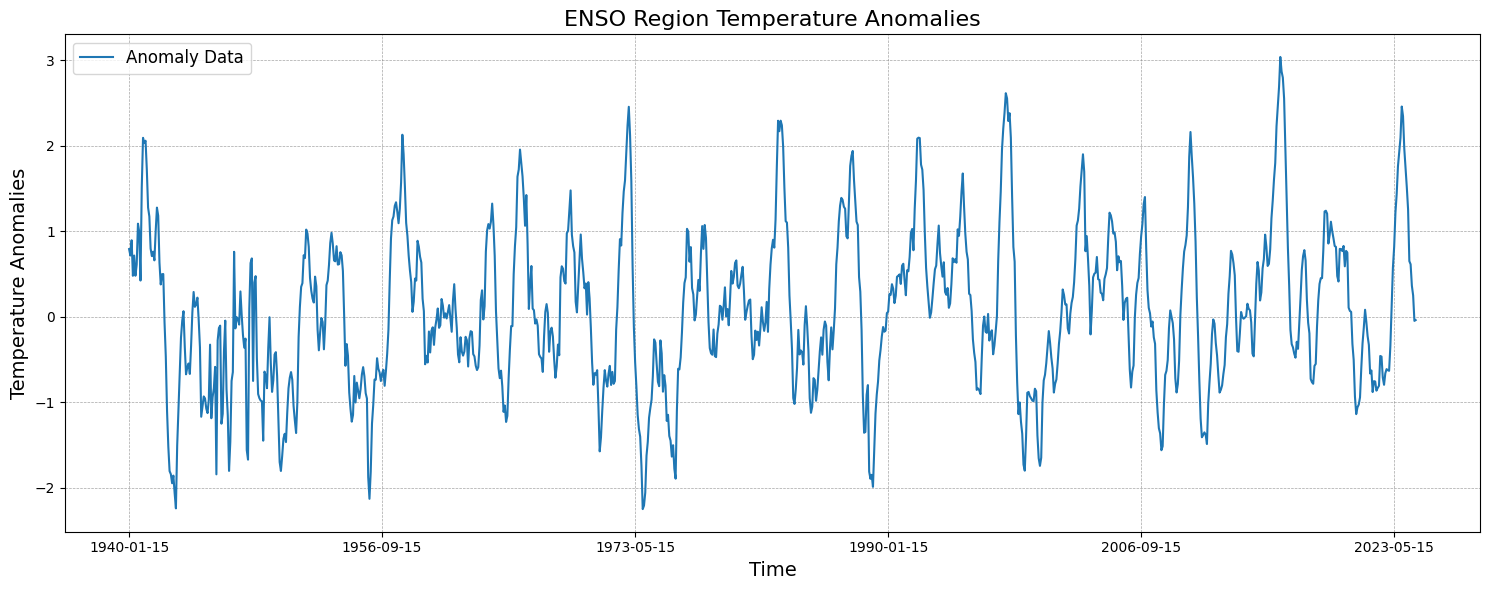

In [76]:
# Plot true values and predictions
plt.figure(figsize=(15, 6))  # Larger figure for better readability

# Training data
plt.plot(data['time'].values, time_series, label="Anomaly Data", linestyle="-")

# # True values
# plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data,
#          label="True Values", linestyle="-", linewidth=2, color="black", marker="x", markersize=8)

# # Predictions
# plt.plot(range(len(train_data), len(train_data) + len(arima_predictions)), arima_predictions,
#          label="ARIMA Predictions", linestyle="--", linewidth=1.5, marker="o", color="#1f77b4", markersize=6)
# plt.plot(range(len(train_data), len(train_data) + len(auto_sarima_predictions)), auto_sarima_predictions,
#          label="AUTO-SARIMA Predictions", linestyle="--", linewidth=1.5, marker="s", color="#2ca02c", markersize=6)
# plt.plot(range(len(train_data), len(train_data) + len(lstm_predictions)), lstm_predictions,
#          label="LSTM Predictions", linestyle="--", linewidth=1.5, marker="d", color="#ff7f0e", markersize=6)
# plt.plot(range(len(train_data), len(train_data) + len(bilstm_predictions)), bilstm_predictions,
#          label="BiLSTM Predictions", linestyle="--", linewidth=1.5, marker="v", color="#9467bd", markersize=6)
# plt.plot(range(len(train_data), len(train_data) + len(gru_predictions)), gru_predictions,
#          label="GRU Predictions", linestyle="--", linewidth=1.5, marker="^", color="#d62728", markersize=6)


plt.xticks(ticks=[0, 200, 400, 600, 800, 1000], labels=data['time'].iloc[[0, 200, 400, 600, 800, 1000]])

# Labels and Title
plt.title("ENSO Region Temperature Anomalies", fontsize=16)
# plt.xaxis(data['time'].values)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)

# Legend
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Grid and Layout
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177]

Training with kernel: RBF


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


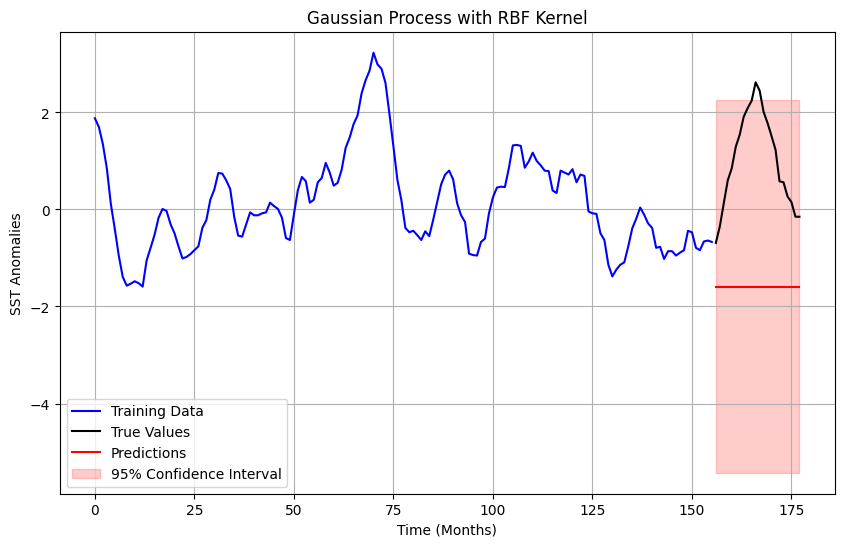


Training with kernel: Periodic (ExpSineSquared)


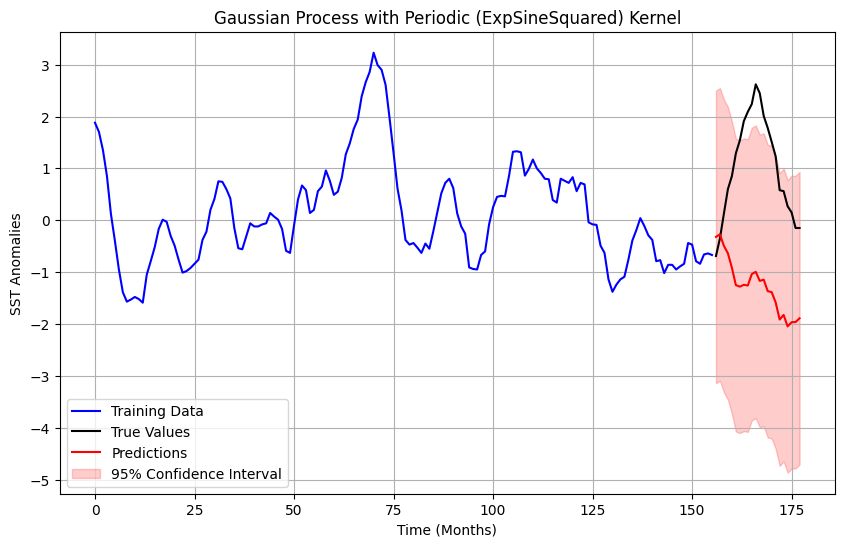


Training with kernel: RBF + Periodic


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


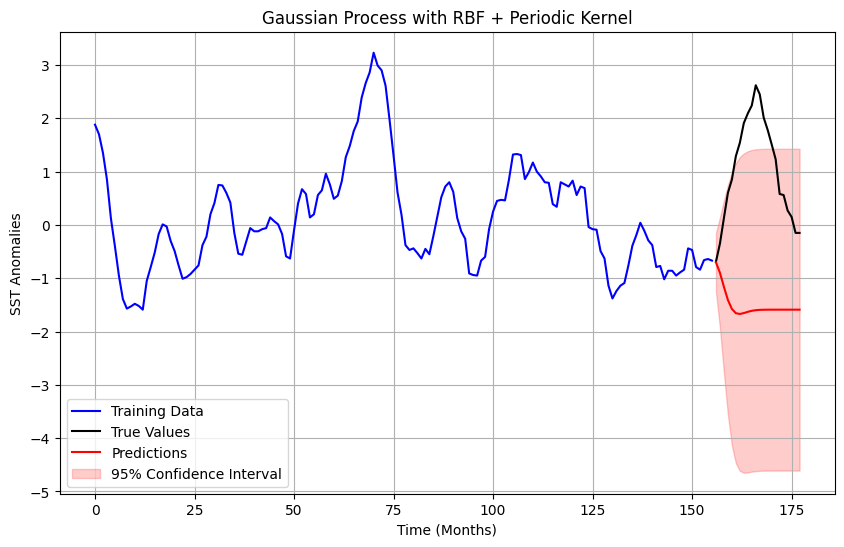


Training with kernel: RBF + WhiteKernel


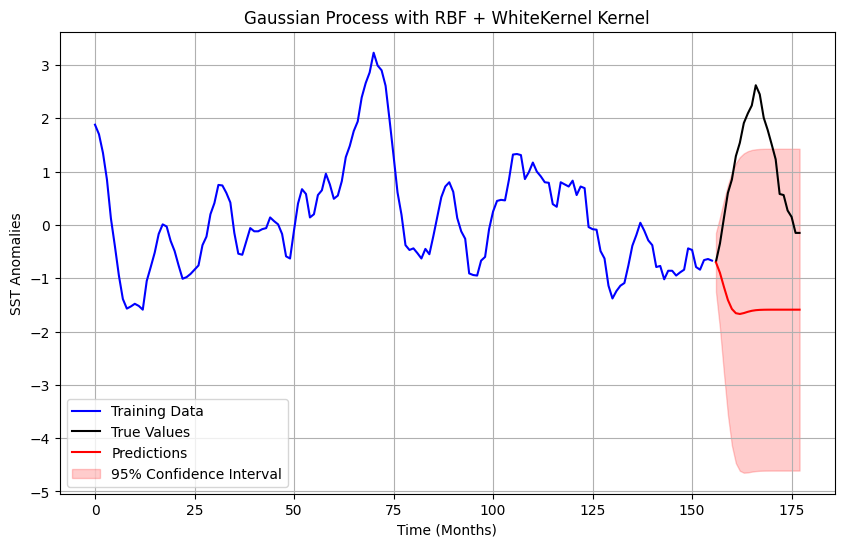


Model Performance:
RBF: {'MAE': 2.6113635322727267, 'RMSE': 2.783874736667323, 'R^2': -7.326671728999489}
Periodic (ExpSineSquared): {'MAE': 2.333722628146766, 'RMSE': 2.540339241197778, 'R^2': -5.933547537403032}
RBF + Periodic: {'MAE': 2.524408573460068, 'RMSE': 2.765680579533544, 'R^2': -7.218188603408624}
RBF + WhiteKernel: {'MAE': 2.5244088357796373, 'RMSE': 2.7656806905412474, 'R^2': -7.2181892631249145}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic example SST data
np.random.seed(42)
data['time_numeric'] = data.index
time = data['time_numeric'].values  # Simulated months
print(time)
sst_anomalies = time_series

# Split into train and test sets
# split_index = int(len(time) - 22)
train_time = time[:split_index]
train_sst = sst_anomalies[:split_index]
test_time = time[split_index:]
test_sst = sst_anomalies[split_index:]

# Normalize the time series (optional)
scaler = (train_sst.min(), train_sst.max())
train_sst_normalized = (train_sst - scaler[0]) / (scaler[1] - scaler[0])
test_sst_normalized = (test_sst - scaler[0]) / (scaler[1] - scaler[0])

# Reshape time for GPR
train_time = train_time.reshape(-1, 1)
test_time = test_time.reshape(-1, 1)

# Define kernels
kernels = {
    "RBF": C(1.0) * RBF(length_scale=10.0),
    "Periodic (ExpSineSquared)": C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=12),
    "RBF + Periodic": C(1.0) * RBF(length_scale=10.0) + C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=12),
    "RBF + WhiteKernel": C(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=0.1),
}

# Fit and evaluate each kernel
results = {}
for kernel_name, kernel in kernels.items():
    print(f"\nTraining with kernel: {kernel_name}")
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10)
    gp.fit(train_time, train_sst_normalized)

    # Predict on test set
    predictions, std_dev = gp.predict(test_time, return_std=True)
    predictions_rescaled = predictions * (scaler[1] - scaler[0]) + scaler[0]  # Rescale predictions

    # Evaluate model
    metrics = evaluate_model(test_sst, predictions_rescaled)
    results[kernel_name] = metrics

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(train_time, train_sst, label="Training Data", color="blue")
    plt.plot(test_time, test_sst, label="True Values", color="black")
    plt.plot(test_time, predictions_rescaled, label="Predictions", color="red")
    plt.fill_between(test_time.flatten(),
                     predictions_rescaled - 1.96 * std_dev * (scaler[1] - scaler[0]),
                     predictions_rescaled + 1.96 * std_dev * (scaler[1] - scaler[0]),
                     alpha=0.2, color="red", label="95% Confidence Interval")
    plt.title(f"Gaussian Process with {kernel_name} Kernel")
    plt.xlabel("Time (Months)")
    plt.ylabel("SST Anomalies")
    plt.legend()
    plt.grid()
    plt.show()

# Display results
print("\nModel Performance:")
for kernel_name, metrics in results.items():
    print(f"{kernel_name}: {metrics}")


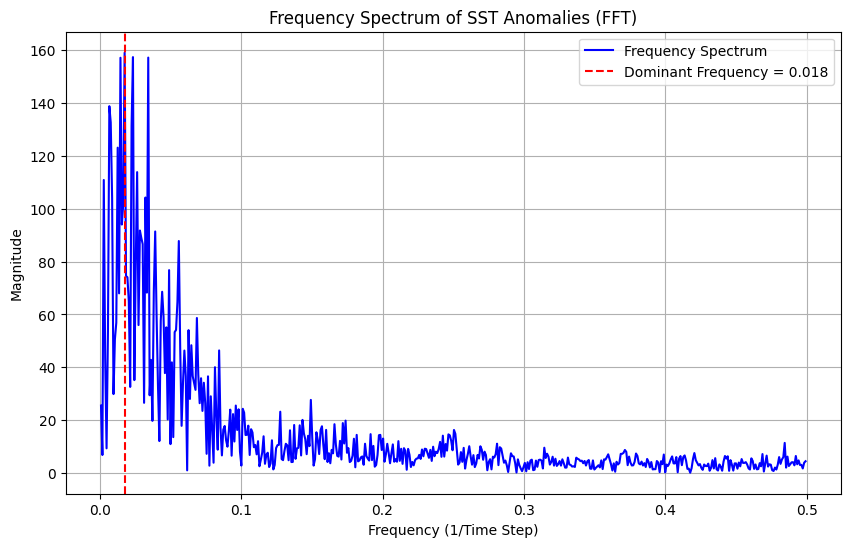

Dominant Period Detected: 56.56 time steps (e.g., months)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Example SST Anomaly Data (replace this with your data)
np.random.seed(42)
# time = np.arange(0, 120, 1)  # Simulated monthly time steps
# sst_anomalies = 0.5 * np.sin(2 * np.pi * time / 12) + 0.2 * np.random.normal(size=len(time)) + 0.1 * time / 120

# Detrend the data (optional)
sst_anomalies_detrended = detrend(time_series)

# Apply FFT
fft_result = np.fft.fft(sst_anomalies_detrended)
frequencies = np.fft.fftfreq(len(fft_result), d=1)  # d=1 corresponds to the time step (monthly)

# Only keep the positive half of the spectrum
positive_freqs = frequencies[frequencies > 0]
positive_magnitudes = np.abs(fft_result[frequencies > 0])

# Find the dominant frequency
dominant_frequency = positive_freqs[np.argmax(positive_magnitudes)]
dominant_period = 1 / dominant_frequency  # Period in time steps (e.g., months)

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_magnitudes, label="Frequency Spectrum", color='blue')
plt.axvline(x=dominant_frequency, color="red", linestyle="--", label=f"Dominant Frequency = {dominant_frequency:.3f}")
plt.title("Frequency Spectrum of SST Anomalies (FFT)")
plt.xlabel("Frequency (1/Time Step)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()

# Print the dominant period
print(f"Dominant Period Detected: {dominant_period:.2f} time steps (e.g., months)")



# Region Mean

In [ ]:
import xarray as xr
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/2024-2025/time_series/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
ds = xr.open_dataset(file_path)

# Define the region bounds
# lat_min, lat_max = 35, 41
# lon_min, lon_max = -50, -39  # Longitude range (degrees east)

lat_min, lat_max = -3, 3
lon_min, lon_max = -153, -147

# Select the region (ensure longitude is in 0-360 range if necessary)
sst_region = ds['tempanomaly'].sel(
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
)

# Compute the mean over the selected region (average across latitude and longitude), skipping NaNs
region_mean = sst_region.mean(dim=["lat", "lon"], skipna=True)

# Drop NaNs in the computed mean
valid_indices = ~region_mean.isnull()  # Identify valid (non-NaN) indices
region_mean_filtered = region_mean.where(valid_indices, drop=True)
valid_time = ds["time"].where(valid_indices, drop=True)  # Ensure time array matches the filtered mean

# Create a DataFrame for the valid time series
region_mean_df = pd.DataFrame({
    "time": valid_time.values,
    "temp_anomaly": region_mean_filtered.values
})

# Filter the dataset to include only data from 2018 onward
filtered_region_mean_df = region_mean_df[region_mean_df['time'] >= '1940-01-01']

# Save the filtered dataset
filtered_output_csv_path = "/content/drive/MyDrive/2024-2025/time_series/region_mean_tempanomaly_from_1940_enso.csv"
filtered_region_mean_df.to_csv(filtered_output_csv_path, index=False)

# Output results
print("Filtered dataset saved to:", filtered_output_csv_path)
print(filtered_region_mean_df.head(10))  # Preview first 10 rows


Filtered dataset saved to: /content/drive/MyDrive/2024-2025/time_series/region_mean_tempanomaly_from_1940_enso.csv
          time  temp_anomaly
720 1940-01-15      0.793750
721 1940-02-15      0.718750
722 1940-03-15      0.896875
723 1940-04-15      0.481250
724 1940-05-15      0.718125
725 1940-06-15      0.481875
726 1940-07-15      0.613125
727 1940-08-15      1.090625
728 1940-09-15      0.994375
729 1940-10-15      0.425625


In [ ]:
region_mean_df

time  temp_anomaly
0    1880-01-15      0.206667
1    1880-02-15     -0.104167
2    1880-03-15     -0.082500
3    1880-04-15      0.486667
4    1880-05-15      0.480833
...         ...           ...
1733 2024-06-15      1.962917
1734 2024-07-15      2.697917
1735 2024-08-15      2.673750
1736 2024-09-15      2.059583
1737 2024-10-15      1.141250

[1738 rows x 2 columns]

In [5]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R^2": r2}

## train(1940-2023) test(2024)

In [72]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv("/content/drive/MyDrive/2024-2025/time_series/region_mean_tempanomaly_from_1940_2.csv")
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [54]:
len(train_data), len(test_data)

(1008, 10)

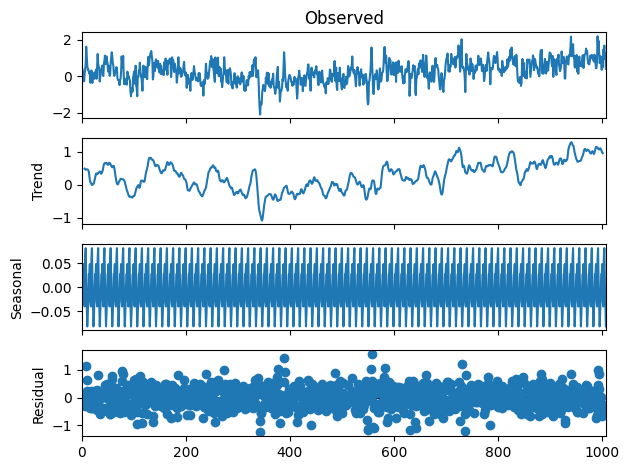

In [55]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [56]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(diff_series)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -4.617174492947259
p-value: 0.00012007490580407918
Series is stationary.


#### Identifying $p, q$

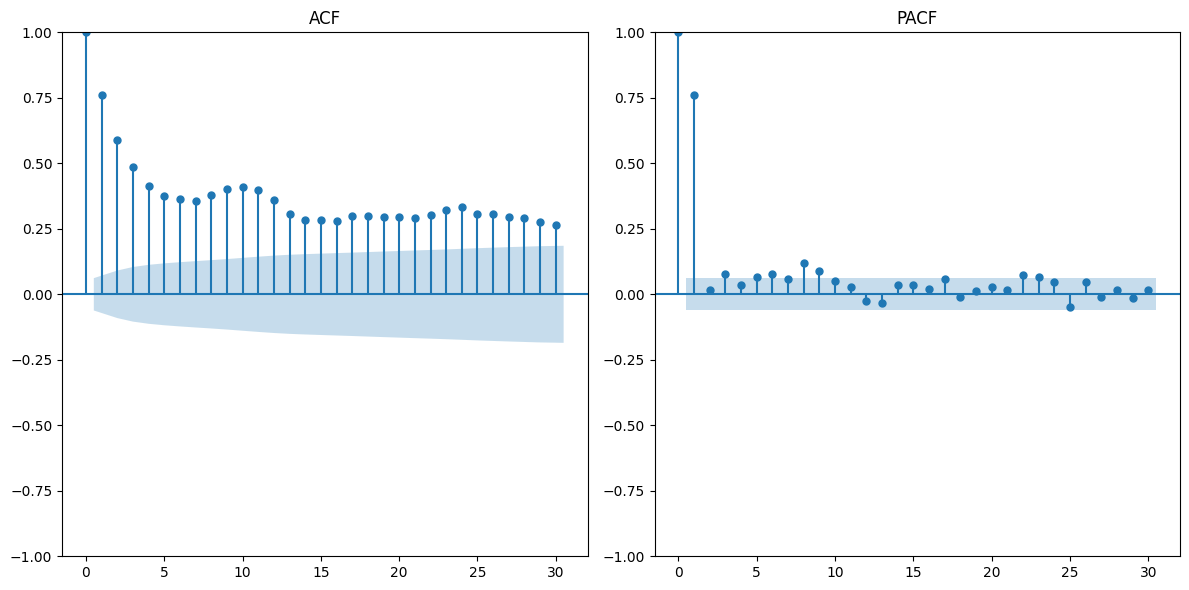

In [57]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [58]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 1.2542830950739716, 'RMSE': 1.4507223042039905, 'R^2': -3.2457214790361704, 'Model': 'ARIMA'}


### Auto-SARIMA

In [59]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=869.753, Time=6.92 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1034.871, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1019.775, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1008.941, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1032.873, Time=0.09 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=869.607, Time=4.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=868.727, Time=6.20 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=869.415, Time=6.40 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=865.726, Time=2.72 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=866.405, Time=8.38 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=866.582, Time=3.79 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=866.653, Time=4.56 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=934.182, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=866.599, Time=3.76 sec
 ARIMA(1,1,3)(0,0,0)[12] inte

In [60]:
print(auto_sarima)

 ARIMA(1,1,2)(0,0,0)[12]          


In [61]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(steps=10)
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 0.7388352205742013, 'RMSE': 0.9603535897251615, 'R^2': -0.860566738022831, 'Model': ' AUTO-SARIMA'}


### LSTM

In [62]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = len(test_data)
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1746
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 16/20
32/32 ━━━━━━━━━━━━

### BiLSTM

In [63]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1729
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 16/20
32/32 ━━━━━━━━━━━━

### GRU

In [64]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1252
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 16/20
32/32 ━━━━━━━━━━━

### Eval Results

In [65]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE      RMSE       R^2         Model
0  1.254283  1.450722 -3.245721         ARIMA
1  0.738835  0.960354 -0.860567   AUTO-SARIMA
2  0.558346  0.675184  0.080341          LSTM
3  0.504491  0.624186  0.214021        BiLSTM
4  0.547047  0.663017  0.113186           GRU


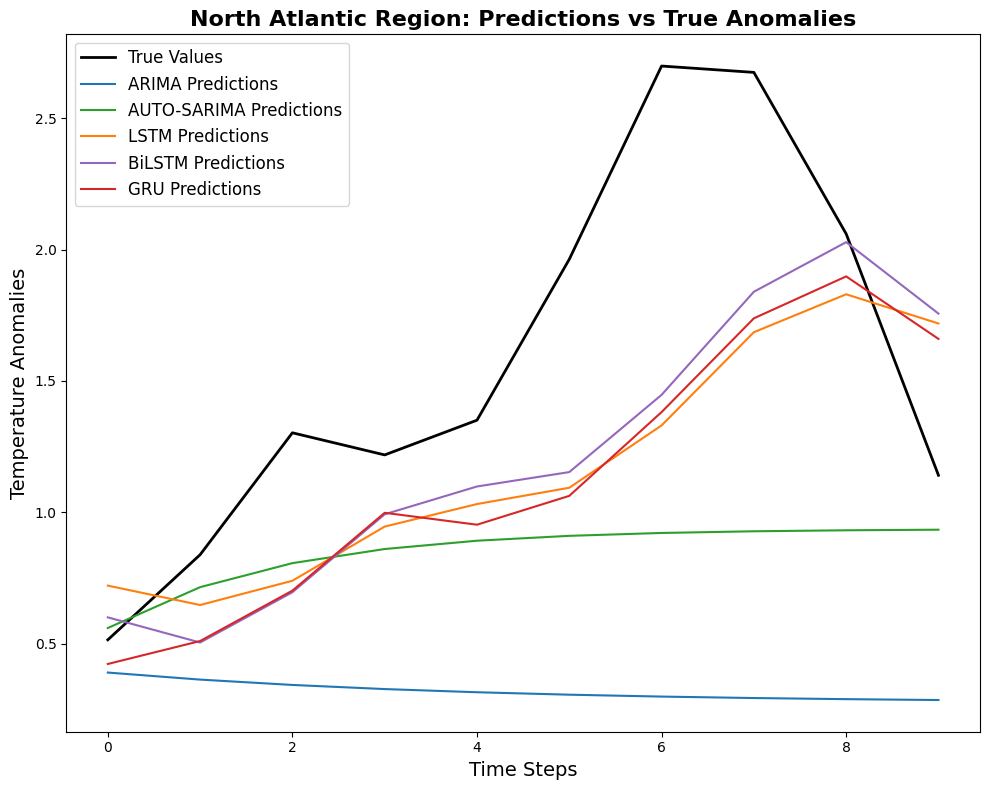

In [67]:
plt.figure(figsize=(10, 8))

plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black")

plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="-", linewidth=1.5, color="#1f77b4")
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="-", linewidth=1.5, color="#2ca02c")
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="-", linewidth=1.5, color="#ff7f0e")
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="-", linewidth=1.5, color="#9467bd")
plt.plot(gru_predictions, label="GRU Predictions", linestyle="-", linewidth=1.5, color="#d62728")

plt.title("North Atlantic Region: Predictions vs True Anomalies", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)
plt.legend(loc="upper left", fontsize=12, frameon=True)

plt.grid(False)
plt.tight_layout()
plt.show()

## ENSO train(1940-2023) test(2024)

In [73]:
# data = pd.read_csv('/content/drive/MyDrive/2024-2025/time_series/enso_spot_tempanomaly.csv')
data = pd.read_csv("/content/drive/MyDrive/2024-2025/time_series/region_mean_tempanomaly_from_1940_enso.csv")
time_series = data['temp_anomaly'].values
time_series = time_series[~np.isnan(time_series)]

# Train-test split
split_index = int(len(time_series)-10)
train_data, test_data = time_series[:split_index], time_series[split_index:]

In [33]:
len(train_data), len(test_data)

(1008, 10)

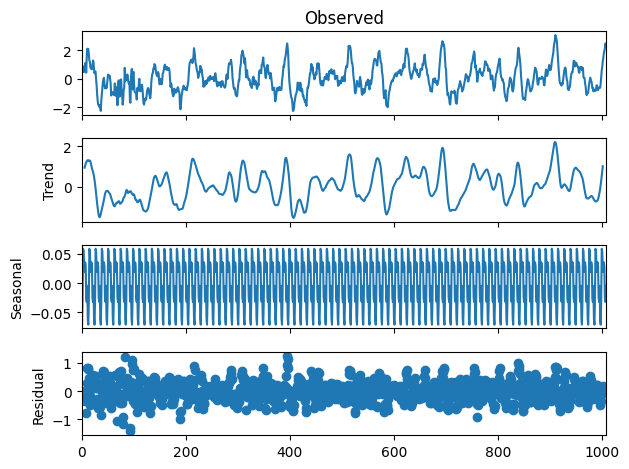

In [34]:
# Decompose the monthly anomaly
result = seasonal_decompose(train_data, model="additive", period=12)
result.plot()
plt.show()

### ARIMA

In [37]:
# Perform ADF test
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is needed.")
    diff_series = np.diff(train_data, n=1)

    # Recheck stationarity
    result = adfuller(train_data)
    print(f"Differenced Series - p-value: {result[1]}")
else:
    print("Series is stationary.")
    diff_series = train_data

ADF Statistic: -7.580990016491241
p-value: 2.6822921605634438e-11
Series is stationary.


In [36]:
diff_series = np.diff(train_data, n=1)

# Recheck stationarity
result = adfuller(train_data)
print(f"Differenced Series - p-value: {result[1]}")

Differenced Series - p-value: 2.6822921605634438e-11


#### Identifying $p, q$

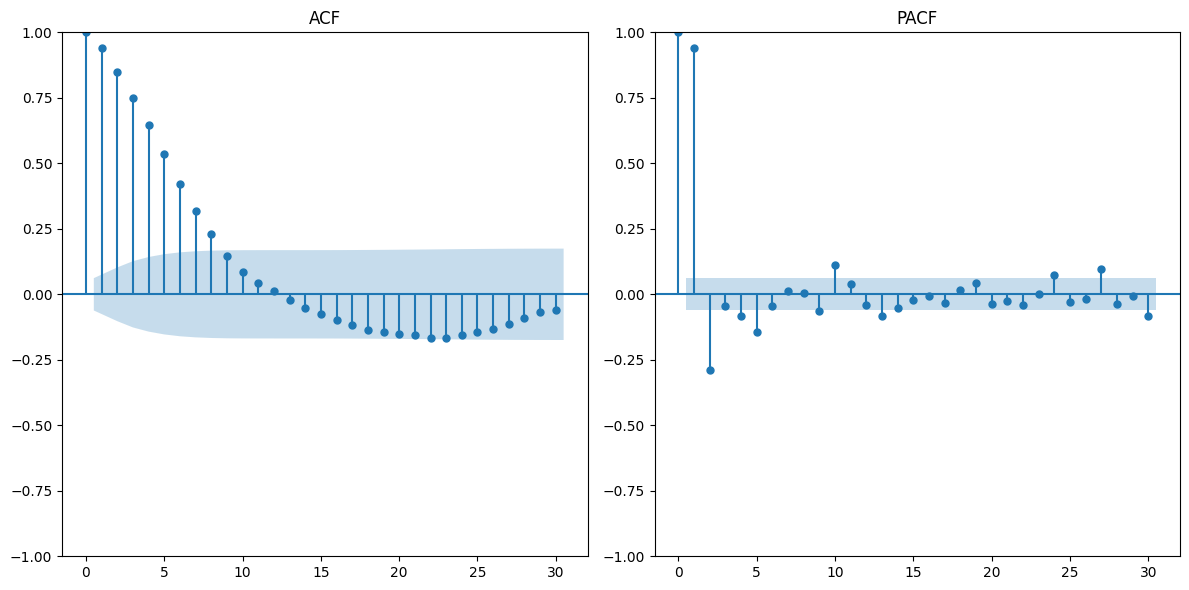

In [38]:
# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title("ACF")

# PACF (for p)
plt.subplot(122)
plot_pacf(diff_series, lags=30, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

In [39]:
# Fit ARIMA model (set p, d, q as needed)
arima_model = ARIMA(train_data, order=(2, 0, 0))  # Adjust (p, d, q) based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Predict on the test set
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA model
arima_metrics = evaluate_model(test_data, arima_predictions)
arima_metrics['Model'] = 'ARIMA'
print(arima_metrics)

{'MAE': 0.5552881847638107, 'RMSE': 0.6234238557116403, 'R^2': 0.21002908493460204, 'Model': 'ARIMA'}


### Auto-SARIMA

In [41]:
auto_sarima = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=469.139, Time=15.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=532.489, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=464.590, Time=1.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=468.667, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=530.513, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=464.025, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=464.666, Time=1.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=464.330, Time=5.32 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=465.975, Time=2.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=465.963, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=467.302, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=467.937, Time=2.46 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=462.038, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=462.605, Time=0.88 sec
 ARIMA(1,1,0)(0,0,1)[12]        

In [42]:
print(auto_sarima)

 ARIMA(1,1,0)(0,0,0)[12]          


In [43]:
auto_sarima_model_fit = auto_sarima.fit(train_data)
auto_sarima_predictions = auto_sarima_model_fit.predict(steps=10)
# Evaluate SARIMA model
auto_sarima_metrics = evaluate_model(test_data, auto_sarima_predictions)
auto_sarima_metrics['Model'] = ' AUTO-SARIMA'
print(auto_sarima_metrics)

{'MAE': 1.4818181663778283, 'RMSE': 1.638544561193417, 'R^2': -4.4570857957568615, 'Model': ' AUTO-SARIMA'}


### LSTM

In [44]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1815
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0083
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0079
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0071
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0075
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0070
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 16/20
32/32 ━━━━

### BiLSTM

In [45]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1419
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0218
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0156
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0147
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0103
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0070
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0080
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0065
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0070
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0058
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053
Epoch 16/20
32

### GRU

In [46]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1705
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0121
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0077
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041
Epoch 16/20
32/32 ━━

### Eval Results

In [47]:
results = pd.DataFrame([arima_metrics, auto_sarima_metrics, lstm_metrics, bilstm_metrics, gru_metrics])
print(results)

# Save to CSV
# results.to_csv("model_performance.csv", index=False)


        MAE      RMSE       R^2         Model
0  0.555288  0.623424  0.210029         ARIMA
1  1.481818  1.638545 -4.457086   AUTO-SARIMA
2  0.194976  0.217828  0.903557          LSTM
3  0.256400  0.302621  0.813858        BiLSTM
4  0.131899  0.147779  0.955611           GRU


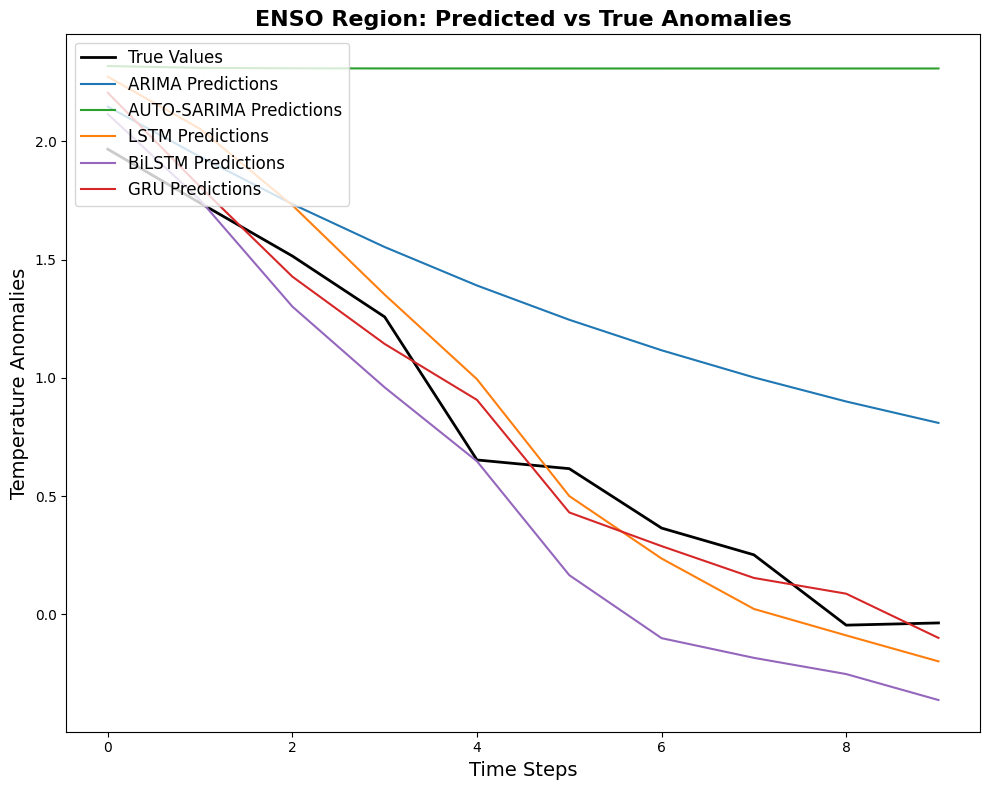

In [52]:
plt.figure(figsize=(10, 8))

plt.plot(test_data, label="True Values", linestyle="-", linewidth=2, color="black")

plt.plot(arima_predictions, label="ARIMA Predictions", linestyle="-", linewidth=1.5, color="#1f77b4")
plt.plot(auto_sarima_predictions, label="AUTO-SARIMA Predictions", linestyle="-", linewidth=1.5, color="#2ca02c")
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="-", linewidth=1.5, color="#ff7f0e")
plt.plot(bilstm_predictions, label="BiLSTM Predictions", linestyle="-", linewidth=1.5, color="#9467bd")
plt.plot(gru_predictions, label="GRU Predictions", linestyle="-", linewidth=1.5, color="#d62728")

plt.title("ENSO Region: Predicted vs True Anomalies", fontsize=16, fontweight="bold")
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Temperature Anomalies", fontsize=14)
plt.legend(loc="upper left", fontsize=12, frameon=True)

plt.grid(False)
plt.tight_layout()
plt.show()
